# Configure font

In [1]:
# Configure Arial as the default font in all figures

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


arial_font_path = '/PATH/TO/ARIAL/FONT/arial.ttf'

# Paths to both font files
arial_font_path = font_dir + 'arial.ttf'
arial_rounded_font_path = font_dir + 'arialroundedmtbold.ttf'

# Register both
fm.fontManager.addfont(arial_font_path)
fm.fontManager.addfont(arial_rounded_font_path)

# Get font properties
arial_font = fm.FontProperties(fname=arial_font_path)
arial_rounded_font = fm.FontProperties(fname=arial_rounded_font_path)

plt.rcParams["font.family"] = "Arial"

# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure 5

## Panel A

In [3]:
import pandas as pd
from os import listdir
from os.path import isfile, join

columns = ['Query','Target','E-value','SeqId','QueryStart', 'QueryEnd','QueryLen', 'TargetStart',
          'TargetEnd','TargetLen', 'Align_len', 'Score', 'QuerySeq', 'TargetSeq', 'mismatch',
           'QueryCov','TargetCov', 'taxid','taxname','taxlineage','lddt','alntmscore','rmsd','prob']

isofolds=pd.read_csv(path+'Fig4/fyn_aln1_AFUniprot',names=columns,sep='\t')

reliable_isofolds = isofolds.loc[isofolds['alntmscore']>0.6].loc[isofolds['prob']==1].loc[isofolds['QueryStart']<3].loc[isofolds['QueryEnd']>53].loc[isofolds['rmsd']<2].drop_duplicates('TargetSeq').copy()

In [4]:
import numpy as np
import logomaker as lm

plt.rcParams["font.family"] = [arial_font.get_name(), arial_rounded_font.get_name()]

aas=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','-']

structure_MSA = pd.DataFrame(columns=np.arange(1,len(reliable_isofolds.iloc[0]['QuerySeq'])+1,1))
for index, row in reliable_isofolds.drop_duplicates('TargetSeq').iterrows():
    query=row.QuerySeq
    target=row.TargetSeq
    query_hyphens=[]
    iterator=0
    for i in query:
        if i=='-':
            query_hyphens.append(iterator)
        iterator+=1
        
    aligned_target=list(target)
    iterator=0
    for i in query_hyphens:
        del(aligned_target[i+iterator])
        iterator-=1
    aligned_target=''.join(aligned_target)
    for i in enumerate(aligned_target):
        structure_MSA.at[row.Target,i[0]+row.QueryStart]=i[1]

structure_MSA.to_csv(path+'Fig5/FYN_SH3_filtered_struct_homologs_MSA_noindel.txt', sep='\t')

In [5]:
import pandas as pd

structure_MSA = pd.read_csv(path+'Fig5/FYN_SH3_filtered_struct_homologs_MSA_noindel.txt', sep='\t',index_col=0)

In [6]:
import logomaker as lm

plt.rcParams["font.family"] = [arial_font.get_name(), arial_rounded_font.get_name()]

aas=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','-']

#GRB2_core=query_natural_DTS_cores.sort_values('Instances',ascending=False).iloc[0].name

cores = {'P06241' : [2,16,18,24,26,48,53]}

logo_df = pd.DataFrame(columns=aas)
    
for pos in range(1,len(structure_MSA.columns)+1,1):
    df = structure_MSA[str(pos)].value_counts().rename_axis('aa').reset_index(name='counts')
    
    for index, row2 in df.iterrows():
        logo_df.at[pos,row2.aa]=int(row2.counts)
logo_df=logo_df.fillna(0)

prob_mat = lm.transform_matrix(logo_df, from_type='counts', to_type='counts')

In [7]:
import Bio.PDB
import numpy as np
from Bio.PDB import PDBParser, PDBIO, Select
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as colors
from operator import itemgetter
import freesasa
from Bio.PDB.ResidueDepth import ResidueDepth
import statistics
from sklearn.cluster import KMeans
import tempfile
from Bio.PDB import PDBIO
from pathlib import Path
pdb_path = str(Path('~/analyses/Cores/final_submission/zenodo/').expanduser())

def calc_residue_dist(residue_one, residue_two) :
    """Returns the minimum distance between any atom in two residues (except for backbone C, O and N)"""
    if 'CB' in residue_one and 'CB' in residue_two:
        all_residue_one_distances=[]
        for atom_one in residue_one:
            atom_one_type=str(atom_one)
            atom_one_type=atom_one_type[6]
            if atom_one_type != 'H' and atom_one != residue_one['N'] and atom_one != residue_one['C'] and atom_one != residue_one['O'] and atom_one != residue_one['CA']:
                all_atom_one_distances=[]
                for atom_two in residue_two:
                    atom_two_type=str(atom_two)
                    atom_two_type=atom_two_type[6]
                    if atom_two_type != 'H' and atom_two != residue_two['N'] and atom_two != residue_two['C'] and atom_two != residue_two['O'] and atom_two != residue_two['CA']:
                        diff_vector = atom_one.coord - atom_two.coord
                        all_atom_one_distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
                all_residue_one_distances.append(min(all_atom_one_distances))
        return min(all_residue_one_distances)

def calc_residue_dist_allatom(residue_one, residue_two) :
    """Returns the minimum distance between any atom in two residues (except for backbone C, O and N)"""
    all_residue_one_distances=[]
    all_residue_one_distances=[]
    for atom_one in residue_one:
        atom_one_type=str(atom_one)
        atom_one_type=atom_one_type[6]
        if atom_one_type != 'H':
            all_atom_one_distances=[]
            for atom_two in residue_two:
                atom_two_type=str(atom_two)
                atom_two_type=atom_two_type[6]
                if atom_two_type != 'H':
                    diff_vector = atom_one.coord - atom_two.coord
                    all_atom_one_distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
            all_residue_one_distances.append(min(all_atom_one_distances))
    return min(all_residue_one_distances)

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    return answer

def calc_dist_matrix_allatom(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            answer[row, col] = calc_residue_dist_allatom(residue_one, residue_two)
    return answer

pdbs = ['5zau']

cc_dict_all={}
cc_ext_dict_all={}

for pdbiterator in pdbs:

    pdb_code = pdbiterator
    pdb_filename = pdb_path + '/FigS6/' + pdb_code + '.pdb'

    #Remove non-protein atoms
    class NonHetSelect(Select):
        def accept_residue(self, residue):
            return 1 if residue.id[0] == " " else 0

    structure_root = Bio.PDB.PDBParser().get_structure(pdb_code, pdb_filename)
    chain = 'A'
    resseqs = {chain.id:[residue.id[1] for residue in chain.get_residues()] for chain in structure_root.get_chains()}

    cc_dict={}
    cc_ext_dict={}
    sasas = pd.DataFrame(columns=resseqs['A'])
    closeness_df = pd.DataFrame(columns=resseqs['A'])
    modelnr=0
    for j in structure_root:
        #grab whatever model and remove heteroatoms
        model = structure_root[modelnr]
        modelnr+=1
        chain = 'A'
        pdb_io = PDBIO()
        pdb_io.set_structure(model[chain])
        
        with tempfile.NamedTemporaryFile(mode='w+', suffix='.pdb') as tmp:
            pdb_io.save(tmp, NonHetSelect())
            tmp.flush()  # Make sure content is written
            tmp.seek(0)

            structure = Bio.PDB.PDBParser().get_structure(pdb_code, tmp.name)
            model = structure[0]
            
            structure_rsa = freesasa.Structure(tmp.name)
            result = freesasa.calc(structure_rsa)

        #calculate maps
        dist_matrix = calc_dist_matrix(model[chain], model[chain])
        contact_map = dist_matrix < 5.0

        dist_matrix_allatom = calc_dist_matrix_allatom(model[chain], model[chain])
        contact_map_allatom = dist_matrix_allatom < 5.0

        #read sequences
        #chains = {chain.id:seq1(''.join(residue.resname for residue in chain)) for chain in structure.get_chains()} #Read amino acid sequence
        resseqs = {chain.id:[residue.id[1] for residue in chain.get_residues()] for chain in structure.get_chains()} #Read sequence numbers

        #seq = chains[chain]
        #seq=list(seq)
        seq_nr=resseqs[chain]

        #Build contact network and calculate RSA
        G = nx.Graph()
        G.add_nodes_from(np.arange(0,len(model[chain]),1))

        labels={}
        node_sizes=[]
        for i in range(0, len(model[chain])):
            labels[i]=i+1
            node_sizes.append((sum(contact_map_allatom[i])-1)*50)
            res_contact_list = list(contact_map_allatom[i])
            res_contact_dist_list = list(dist_matrix_allatom[i])
            for (j,k,l) in zip(res_contact_list, range(0, len(model[chain])), res_contact_dist_list):
                if j == True:
                    G.add_edge(i,k,length=l)


        #Set node 'size' attributes
        for n, data in G.nodes(data=True):
            data['size'] = node_sizes[n]

        #Calculate per residue RSA - https://github.com/freesasa/freesasa-python/pull/14 | https://github.com/freesasa/freesasa-python/issues/3

        residueAreas1 = result.residueAreas()
        residueTotal1 = dict(map(lambda x: (x[0], x[1].relativeTotal), residueAreas1['A'].items()))

        freesasa_list=[]
        for key, value in residueTotal1.items():
            freesasa_list.append(value)
        
        G=nx.relabel_nodes(G,labels)

        #Amazing source of all that follows: https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

        betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
        eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
        katz_dict = nx.katz_centrality_numpy(G) # Run katz centrality | Regular katz_centrality fails with all atom contact networks, fix: https://stackoverflow.com/questions/43208737/using-networkx-to-calculate-eigenvector-centrality
        closeness_dict = nx.closeness_centrality(G)

        # Assign each to an attribute in your network
        nx.set_node_attributes(G, betweenness_dict, 'betweenness')
        nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
        nx.set_node_attributes(G, katz_dict, 'katz')
        nx.set_node_attributes(G, closeness_dict, 'closeness')

        #Generate centrality lists
        eigenvector_list=[]
        katz_list=[]
        betweenness_list=[]
        closeness_list=[]
        for (key, value), (key2, value2), (key3, value3), (key4, value4) in zip(eigenvector_dict.items(), katz_dict.items(), betweenness_dict.items(), closeness_dict.items()):
            eigenvector_list.append(value)
            katz_list.append(value2)
            betweenness_list.append(value3)
            closeness_list.append(value4)

        katz_list_norm=[float(i-min(katz_list))/float(max(katz_list)-min(katz_list)) for i in katz_list]
        closeness_list_norm=[float(i-min(closeness_list))/float(max(closeness_list)-min(closeness_list)) for i in closeness_list]
        freesasa_list_norm=[float(i-min(freesasa_list))/float(max(freesasa_list)-min(freesasa_list)) for i in freesasa_list]
        
        sasas.loc[modelnr]=freesasa_list
        closeness_df.loc[modelnr]=closeness_list

        X = np.array(list(zip(closeness_list_norm, freesasa_list_norm)))
        kmeans = KMeans(n_clusters=3, n_init=1000, max_iter=100000).fit(X) # https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/
        centroids = kmeans.cluster_centers_
        labels = kmeans.predict(X)


        s=np.argsort(centroids.T[1]) #find indices of sorted RSA values
        central_core=(labels==s[0])
        central_core=[i+int(seq_nr[0]) for i, x in enumerate(central_core) if x]
        boundary=(labels==s[1])
        boundary=[i+int(seq_nr[0]) for i, x in enumerate(boundary) if x]
        surface=(labels==s[2])
        surface=[i+int(seq_nr[0]) for i, x in enumerate(surface) if x]

        cc_index= [i - seq_nr[0] for i in central_core]

closeness_list=closeness_df.mean().to_list()
freesasa_list= sasas.mean().to_list()

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

def gini_index(frequencies):
    n = len(frequencies)
    if np.sum(frequencies) == 0:
        return 0 
    sorted_frequencies = np.sort(frequencies)
    cumulative_frequencies = np.cumsum(sorted_frequencies)
    numerator = np.sum(np.abs(cumulative_frequencies - np.cumsum(sorted_frequencies[::-1])))
    denominator = n * np.sum(sorted_frequencies)
    return numerator / denominator

def shannon_entropy(frequencies):
    frequencies = np.array(frequencies)
    if np.sum(frequencies) == 0:
        return 0
    probabilities = frequencies / np.sum(frequencies)
    return entropy(probabilities, base=2)

frac_df = pd.DataFrame(columns=logo_df.columns)
for index, row in logo_df.iterrows():
    frac_df.loc[index]=row/row.sum()

gini_indices = frac_df.apply(gini_index, axis=1)
shannon_entropies = frac_df.T.apply(shannon_entropy, axis=0)

In [9]:
closeness_list_norm=[float(i-min(closeness_list))/float(max(closeness_list)-min(closeness_list)) for i in closeness_list]
freesasa_list_norm=[float(i-min(freesasa_list))/float(max(freesasa_list)-min(freesasa_list)) for i in freesasa_list]
gini_indices_norm=[float(i-min(list(gini_indices)))/float(max(list(gini_indices))-min(list(gini_indices))) for i in list(gini_indices)]
shannon_entropies_norm=[float(i-min(list(shannon_entropies)))/float(max(list(shannon_entropies))-min(list(shannon_entropies))) for i in list(shannon_entropies)]

X = np.array(list(zip(closeness_list_norm, freesasa_list_norm, gini_indices_norm, shannon_entropies_norm)))
kmeans = KMeans(n_clusters=3, n_init=1000, max_iter=100000, random_state=0).fit(X) # https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/
centroids = kmeans.cluster_centers_
labels = kmeans.predict(X)
labels[43] = 2
s=np.argsort(np.argsort(centroids.T[1]))
sasa_groups=labels.copy()

In [10]:
from dogma import GeneticCode
from dogma.extensions import CodonSelector
import pandas as pd

aminoacids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y','*']

genetic_code_cerevisiae_usage = {'F':['TTT','TTC'],
                                'L':['TTG','TTA','CTA','CTT','CTG','CTC'],
                                'Y':['TAT','TAC'],
                                'H':['CAT','CAC'],
                                'Q':['CAA','CAG'],
                                'I':['ATT','ATA','ATC'],
                                'M':['ATG'],
                                'N':['AAT','AAC'],
                                'K':['AAA','AAG'],
                                'V':['GTT','GTC','GTA','GTG'],
                                'D':['GAT','GAC'],
                                'E':['GAA','GAG'],
                                'S':['TCT','TCA','TCC','AGT','AGC','TCG'],
                                'C':['TGT','TGC'],
                                'W':['TGG'],
                                'P':['CCA','CCT','CCC','CCG'],
                                'R':['AGA','AGG','CGT','CGA','CGC','CGG'],
                                'A':['GCT','GCA','GCC','GCG'],
                                'G':['GGT','GGA','GGC','GGG'],
                                'T':['ACT','ACA','ACC','ACG'],
                                '*':['TAA','TGA','TAG']}

IUPAC_nucl_code = {'A': 'A',
                   'T': 'T',
                   'G': 'G',
                   'C': 'C',
                   'R': ['A', 'G'],
                   'Y': ['C', 'T'],
                   'S': ['G', 'C'],
                   'W': ['A', 'T'],
                   'K': ['G', 'T'],
                   'M': ['A', 'C'],
                   'B': ['C', 'G', 'T'],
                   'D': ['A', 'G', 'T'],
                   'H': ['A', 'C', 'T'],
                   'V': ['A', 'C', 'G'],
                   'N': ['A', 'T', 'G', 'C']}

supE = GeneticCode(ncbi_id=1)

must_exclude = []
cs = CodonSelector(
    genetic_code=supE,
    must_exclude=must_exclude
)

subset=cs.filtered_table.sort_values('Num_uAAs', ascending=False)


label_freqs=pd.DataFrame()
temp_columns = {}
for index, row in subset.iterrows():
    #print(row['Labels'])
    a=list(row['AAs'])

    all_aa=[]
    for i in a:
        if i not in all_aa:
            all_aa.append(i)
    
    aa_df = pd.DataFrame(columns=['Residue', 'Residue_frequency'])
    l=0
    for j in all_aa:
        k=0
        for i in a:
            if j==i:
                k+=1
        residue_freq=k/len(a)
        aa_df.loc[l] = [j, round(residue_freq,10)]
        l+=1
        
    aa_df.set_index('Residue', inplace=True)

    temp_columns[row['Labels']] = aa_df['Residue_frequency']
    temp_columns[row['Labels']].at['Num_Codons'] = row.Num_Codons
    
    
    deg_codon = list(row.Labels)

    pos1 = []
    pos2 = []
    pos3 = []
    for i in deg_codon:
        for key, value in IUPAC_nucl_code.items():
            if i == key and not pos1:
                pos1 = value
            elif i == key and not pos2:
                pos2 = value
            elif i == key and not pos3:
                pos3 = value
    
    unfolded_codon = []
    for i in pos1:
        for j in pos2:
            for k in pos3:
                unfolded_codon.append(i + j + k)
                
    ranks=[]
    for aa in row.uAAs:
        for codon in genetic_code_cerevisiae_usage[aa]:
            if codon in unfolded_codon:
                ranks.append(genetic_code_cerevisiae_usage[aa].index(codon))
    temp_columns[row['Labels']].at['codon_usage_rank'] = sum(ranks)
    
label_freqs = pd.concat(temp_columns.values(), axis=1)
label_freqs.columns = temp_columns.keys()
label_freqs=label_freqs.reindex(aminoacids+['Num_Codons','codon_usage_rank'])

In [11]:
import numpy as np
from decimal import Decimal
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
import seaborn as sns
fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'
frac_df = pd.DataFrame(columns=logo_df.columns)
for index, row in logo_df.iterrows():
    frac_df.loc[index]=row/row.sum()

for index, row in frac_df.iterrows():
    shannon_entropy = 1 - shannon_entropies_norm[row.name-1]
    for column in frac_df.columns:
        if row[column]<(shannon_entropy*0.1) or column=='-':
            frac_df.at[index,column]=0
#frac_df=frac_df.drop('-',axis=1)
frac_df.rename(columns={'-':'*'}, inplace=True)
for index, row in frac_df.iterrows():
    frac_df.loc[index] = row/row.sum()

frac_df=frac_df.T
frac_df

genetic_code_cerevisiae_usage = {'F':['TTT','TTC'],
                                'L':['TTG','TTA','CTA','CTT','CTG','CTC'],
                                'Y':['TAT','TAC'],
                                'H':['CAT','CAC'],
                                'Q':['CAA','CAG'],
                                'I':['ATT','ATA','ATC'],
                                'M':['ATG'],
                                'N':['AAT','AAC'],
                                'K':['AAA','AAG'],
                                'V':['GTT','GTC','GTA','GTG'],
                                'D':['GAT','GAC'],
                                'E':['GAA','GAG'],
                                'S':['TCT','TCA','TCC','AGT','AGC','TCG'],
                                'C':['TGT','TGC'],
                                'W':['TGG'],
                                'P':['CCA','CCT','CCC','CCG'],
                                'R':['AGA','AGG','CGT','CGA','CGC','CGG'],
                                'A':['GCT','GCA','GCC','GCG'],
                                'G':['GGT','GGA','GGC','GGG'],
                                'T':['ACT','ACA','ACC','ACG'],
                                '*':['TAA','TGA','TAG']}


aminoacid_groups = {'negative':['D','E'],
                    'positive':['K','R'],
                    'apolar_small':['A','V'],
                    'apolar_bulky':['I','L','M'],
                    'aromatic':['F','Y','W'],
                    'polar':['Q','N'],
                    'S/T':['S','T'],
                    'P':['P'],
                    'G':['G'],
                    'C':['C'],
                    'H':['H'],
                    '*':['*']}

kmeans_keys = {}

res_groups=np.arange(0,5,1)

for kmeans_key, res_group in zip(list(s),res_groups):
    kmeans_keys[res_group]=kmeans_key

sorted_res_categories = np.array([kmeans_keys[i] for i in list(sasa_groups)]).reshape(57,1)

aminoacids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y','*']
#label_freqs=label_freqs.reindex(aminoacids+['Num_Codons'])
deg_codons_df=pd.DataFrame(columns=['Residue'])
deg_codons_df['Residue']=aminoacids
deg_codons_df.set_index('Residue', inplace=True)
nr_of_variants=1
#for residue, real_freqs in frac_df[8].to_frame().items():
for residue, real_freqs in frac_df.items():
    deg_target_MSE=[]
    deg_target_diff_df = label_freqs.copy()
    for codon, codon_freqs in label_freqs[:-2].items():
        deg_target_diff=[]
        for i, j in zip(real_freqs, codon_freqs):
            if np.isnan(i):
                i=0
            if np.isnan(j):
                j=0
            deg_target_diff.append((j-i)**2)
        deg_target_MSE.append(sum(deg_target_diff)/len(codon_freqs))
        deg_target_diff_df.at['MSE',codon]=sum(deg_target_diff)/len(codon_freqs)
    
    sorted_deg_target_diff_df=deg_target_diff_df.T.sort_values(['MSE','Num_Codons'],ascending=[True,True]).copy()
    
    must_include = [fyn_wt[residue-1]]# + list(frac_df[residue][frac_df[residue]>0].index)
    for index, row in frac_df[residue].to_frame().iterrows():
        if row.values[0] > 0.3:
            must_include.append(index)
            
    aa_groups_prevalence = pd.DataFrame()
    for key, value in aminoacid_groups.items():
        prop = 0
        for res in value:
            prop=prop+frac_df[residue].to_frame().loc[res][residue]
        aa_groups_prevalence.at[key,'prevalence']=prop
    aa_groups_prevalence
    
    for index, row in aa_groups_prevalence.iterrows():
        if row.prevalence > 0.3:
            if len(list(set(must_include).intersection(set(aminoacid_groups[index]))))==0:
                must_include.append(frac_df[residue].to_frame().loc[aminoacid_groups[index]].nlargest(1,residue).iloc[0].name)
            
    real_residues = list(set(list(real_freqs[real_freqs>0].index)+must_include))
    diversity_sorted_deg_target_diff_df=sorted_deg_target_diff_df.copy()
    diversity_sorted_deg_target_diff_df['includes_fyn_wt'] = diversity_sorted_deg_target_diff_df.get('includes_fyn_wt', pd.Series(index=diversity_sorted_deg_target_diff_df.index)).astype(object)
    diversity_sorted_deg_target_diff_df['stop'] = diversity_sorted_deg_target_diff_df.get('stop', pd.Series(index=diversity_sorted_deg_target_diff_df.index)).astype(object)
    diversity_sorted_deg_target_diff_df['all_in_real'] = diversity_sorted_deg_target_diff_df.get('all_in_real', pd.Series(index=diversity_sorted_deg_target_diff_df.index)).astype(object)
    for index, row in sorted_deg_target_diff_df.iterrows():
        in_real_residues = []
        if set(must_include).issubset([aa for aa in list(row[row>0].index) if aa in aminoacids]):
            diversity_sorted_deg_target_diff_df.at[index,'includes_fyn_wt']=True
            if '*' in [aa for aa in list(row[row>0].index) if aa in aminoacids]:
                diversity_sorted_deg_target_diff_df.at[index,'stop']=True
            else:
                diversity_sorted_deg_target_diff_df.at[index,'stop']=False
            for i in [aa for aa in list(row[row>0].index) if aa in aminoacids]:
                if i in real_residues:
                    in_real_residues.append(True)
                else:
                    in_real_residues.append(False)
            diversity_sorted_deg_target_diff_df.at[index,'Num_real_aas']=in_real_residues.count(True)
            if all(in_real_residues):
                diversity_sorted_deg_target_diff_df.at[index,'all_in_real']=True
            else:
                diversity_sorted_deg_target_diff_df.at[index,'all_in_real']=False
        else:
            diversity_sorted_deg_target_diff_df.at[index,'includes_fyn_wt']=False
            
    try:
        optimal_deg=diversity_sorted_deg_target_diff_df.loc[diversity_sorted_deg_target_diff_df['includes_fyn_wt']==True].loc[diversity_sorted_deg_target_diff_df['all_in_real']==True].sort_values(['Num_real_aas','Num_Codons','MSE','codon_usage_rank'],ascending=[False,True,True,True]).iloc[0].name
    except IndexError:
        try:
            optimal_deg=diversity_sorted_deg_target_diff_df.loc[diversity_sorted_deg_target_diff_df['includes_fyn_wt']==True].loc[diversity_sorted_deg_target_diff_df['stop']==False].sort_values(['Num_real_aas','Num_Codons','MSE','codon_usage_rank'],ascending=[False,True,True,True]).iloc[0].name
        except IndexError:
            optimal_deg=diversity_sorted_deg_target_diff_df.loc[diversity_sorted_deg_target_diff_df['includes_fyn_wt']==True].sort_values(['Num_real_aas','Num_Codons','MSE'],ascending=[False,True,True]).iloc[0].name
    label_freqs_column=label_freqs[optimal_deg].copy()
    deg_codons_df[str(residue)+'_'+optimal_deg]=label_freqs_column
    nr_aas=0
    for index, row in diversity_sorted_deg_target_diff_df.loc[optimal_deg].to_frame().iterrows():
        if row.iloc[0] > 0 and index in aminoacids:
            nr_aas+=1
    nr_aas
    nr_of_variants=nr_of_variants*nr_aas


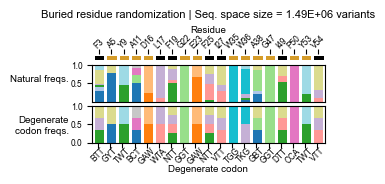

In [12]:
import math
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib import colors
norm = colors.Normalize(vmin=0, vmax=1)
plt.rcParams['font.family'] = 'Arial'
mut_pos_core = np.where(sorted_res_categories == 0)[0].tolist()

real_mut_pos_core = [j+1 for j in mut_pos_core]

extended_core_pos = [5,9,11,16,22,23,35,36,38,44,47,50,53]
core_pos = [i for i in real_mut_pos_core if i not in extended_core_pos]
core_array = np.array([1 if pos in extended_core_pos else 0 for pos in real_mut_pos_core])

core_frac_df = frac_df.T.loc[[i+1 for i in mut_pos_core]]
core_deg_cod = deg_codons_df.T.copy()
core_deg_cod = core_deg_cod.reset_index(drop=False)
core_deg_cod.index +=1
core_deg_cod = core_deg_cod.loc[[i+1 for i in mut_pos_core]]
core_deg_cod.index = core_deg_cod['index']

new_colors = ['black','#D59C2A']
new_cmap_2 = ListedColormap(new_colors)

fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'
fig = plt.figure(figsize=(3, 1))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 5, 5], hspace=0.15)

ax_sequence = fig.add_subplot(gs[0, 0])
ax_natural_freqs = fig.add_subplot(gs[1, 0])
ax_deg_codons = fig.add_subplot(gs[2, 0])

core_frac_df.plot(kind='bar', stacked=True, legend=False, ax=ax_natural_freqs, cmap='tab20')
ax_natural_freqs.set_yticks(np.arange(0.5, 1.2, 0.5))
ax_natural_freqs.set_yticklabels(np.arange(0.5, 1.2, 0.5), fontsize=6)
ax_natural_freqs.set_ylabel('Natural freqs.', fontsize=7, rotation=0, labelpad=-10)
ax_natural_freqs.yaxis.label.set_ha("right")
ax_natural_freqs.yaxis.set_label_coords(-0.1, 0.5) 
ax_natural_freqs.yaxis.tick_left()
ax_natural_freqs.set_ylim(0, 1)
ax_natural_freqs.set_xticks([])

core_deg_cod.plot(kind='bar', stacked=True, cmap='tab20', ax=ax_deg_codons, legend=False)
ax_deg_codons.set_yticks(np.arange(0, 1.2, 0.5))
ax_deg_codons.set_yticklabels(np.arange(0, 1.2, 0.5), fontsize=6)
ax_deg_codons.set_ylabel('\nDegenerate\ncodon freqs.', fontsize=7, rotation=0, labelpad=-10)
ax_deg_codons.yaxis.label.set_ha("right")
ax_deg_codons.yaxis.set_label_coords(-0.1, 0.2) 
ax_deg_codons.yaxis.tick_left()
ax_deg_codons.set_ylim(0, 1)
ax_deg_codons.set_xticklabels([i.get_text().split('_')[1] for i in ax_deg_codons.get_xticklabels()], fontsize=6, rotation=45)
ax_deg_codons.tick_params(axis='x', pad=-1)
ax_deg_codons.set_xlabel('Degenerate codon', fontsize=7, labelpad=-1)

for container in ax_natural_freqs.containers + ax_deg_codons.containers:
    for bar in container:
        bar.set_width(0.75)
        
heatmap = sns.heatmap(
    core_array.reshape(1, 19), cmap=new_cmap_2, norm=norm,
    cbar=False, linewidths=1, linecolor='white', square=False, ax=ax_sequence
)
ax_sequence.set_yticks([])
ax_sequence.set_xticks(np.arange(0.5,len(mut_pos_core),1))
ax_sequence.set_xticklabels([fyn_wt[i]+str(i+1) for i in mut_pos_core], fontsize=6)
ax_sequence.xaxis.set_ticks_position("top")
ax_sequence.xaxis.set_label_position("top")
ax_sequence.tick_params(axis='x', rotation=45, pad=-1)
ax_sequence.set_xlabel('Residue',fontsize=7, labelpad=-1)

ax_natural_freqs.set_xlim(-0.5, len(core_frac_df)-0.4)
ax_deg_codons.set_xlim(-0.5, len(core_frac_df)-0.4)
ax_sequence.set_xlim(-0.1,len(core_array))

handles, labels = ax_deg_codons.get_legend_handles_labels()
legend_columns = [core_frac_df[column].name for column in core_frac_df.columns if core_frac_df[column].sum() > 0]
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l in legend_columns]
filtered_handles, filtered_labels = zip(*filtered_handles_labels) if filtered_handles_labels else ([], [])
filtered_handles_circles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=h.patches[0].get_facecolor(), markersize=6, markeredgewidth=0)
    for h in filtered_handles
]

for ax in [ax_natural_freqs, ax_deg_codons]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.8)

res_per_pos =[]
for column in core_deg_cod.drop('index',axis=1).T.columns:
    res_per_pos.append(core_deg_cod.drop('index',axis=1).T[column].count())

ax_sequence.set_title('Buried residue randomization | Seq. space size = ' + str("{:.2E}".format(math.prod(res_per_pos))) + ' variants', fontsize=8)

fig.subplots_adjust(hspace=1, wspace= 0.05,top=1)

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Core_mutagenesis_design.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel B

In [13]:
groups = ['core','boundary','surface']
for G in kmeans_keys.keys():
    print('select '+str(groups[G])+', (chain A and resid '+str([i+int(seq_nr[0]) for i, x in enumerate(list(sorted_res_categories.ravel())) if x == G])[1:-1].replace(' ', '')+')')

select core, (chain A and resid 87,89,93,95,100,101,103,106,107,109,111,119,120,122,131,133,134,137,138)
select boundary, (chain A and resid 86,88,102,108,110,113,114,121,123,124,125,128,129,130,132,135,139)
select surface, (chain A and resid 85,90,91,92,94,96,97,98,99,104,105,112,115,116,117,118,126,127,136,140,141)


## Panel C

In [14]:
import pandas as pd

allvariants = pd.read_csv(path+'Fig5/FYN_buried_n_exposed_randomization_fitness_replicates.txt',
                         sep='\t', low_memory=False)

allvariants = allvariants.sort_values('fitness', ascending=False)

In [15]:
### Library demultiplexing ###

from Bio.Seq import Seq

fiveprimeseq_233nt = 'ATCTTCcacatttccccgaaaagtgccTAGGGCTAGC'
threeprimeseq_233nt= 'AAGCTTcgcaggaaagaacatgtga'

degenerate_oligo_seqs_df=pd.read_excel(path+'Fig5/degenerate_oligo_seqs_df_full_layers_v2.xlsx',index_col=0)

degenerate_oligo_seqs_df['aa_seq']=pd.Series(dtype="object") 
for index, row in degenerate_oligo_seqs_df.iterrows():
    degenerate_oligo_seqs_df.at[index,'aa_seq' ]= str(Seq(row['233nt_seq'][len(fiveprimeseq_233nt):row['233nt_seq'].find(threeprimeseq_233nt.upper())]).translate()).replace('B', 'X').replace('J', 'X').replace('Z', 'X')

adhoc_libs = degenerate_oligo_seqs_df.iloc[np.r_[0:4, 9:11]].copy()
adhoc_libs['num_mut_pos']=pd.Series(dtype="object") 
for index, row in adhoc_libs.iterrows():
    adhoc_libs.at[index,'num_mut_pos'] = str(row.aa_seq.count('X'))

count_X = [s.count('X') for s in list(adhoc_libs['aa_seq'])]

sorted_counts = sorted(count_X, reverse=True)

ranks = [sorted_counts.index(count) + 1 for count in count_X]

adhoc_libs['rank']=ranks

var_vs_libs = adhoc_libs.copy()

string1 = "TAFVALFDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV"

var_vs_libs['var_diffs']=pd.Series(dtype="object") 
for index_vars, row_vars in allvariants.iterrows():
    for index, row in var_vs_libs.iterrows():
        differences = []
        for i, (char1, char2) in enumerate(zip(row.aa_seq, row_vars.aa_seq)):
            if char1 != 'X' and char1 != char2:
                differences.append((i, char1, char2))
        var_vs_libs.at[index,'var_diffs']=str(len(differences))
    
    allvariants.at[index_vars, 'library']=var_vs_libs.sort_values(['var_diffs','rank'], ascending=[True,False]).iloc[0]['Description']

/tmp/15480749/ipykernel_69704/3003046495.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Ad-hoc_surface_half2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  allvariants.at[index_vars, 'library']=var_vs_libs.sort_values(['var_diffs','rank'], ascending=[True,False]).iloc[0]['Description']


In [16]:
# Find Hamming distance to WT

for index, row in allvariants.iterrows():
    if row.aa_seq == fyn_wt:
        allvariants.at[index, 'real_Nham_aa'] = 0
    else:
        allvariants.at[index, 'real_Nham_aa'] = sum(1 for a,b in zip(fyn_wt, row.aa_seq) if a!=b)

In [17]:
### Fitness scaling ###

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import kdeplot
import numpy as np

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]
def normalize_errors(values, bounds):
    return [x * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

# Normalize data in the -1 to 0 range
reference=allvariants.sort_values(['real_Nham_aa', 'fitness'], ascending=[True, False]).iloc[0]['aa_seq']
fig = plt.figure()
lines = kdeplot(data=allvariants,x='fitness',linewidth=1).get_lines()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
plt.close()
    
allvariants_scaled = allvariants.copy()    

allvariants_scaled['fitness']=normalize(list(allvariants_scaled['fitness']),{'actual': {'lower': mode, 'upper': allvariants_scaled.loc[allvariants_scaled['aa_seq']==reference]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
allvariants_scaled['fitness1_uncorr']=normalize(list(allvariants_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': allvariants_scaled.loc[allvariants_scaled['aa_seq']==reference]['fitness1_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
allvariants_scaled['fitness2_uncorr']=normalize(list(allvariants_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': allvariants_scaled.loc[allvariants_scaled['aa_seq']==reference]['fitness2_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
allvariants_scaled['fitness3_uncorr']=normalize(list(allvariants_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': allvariants_scaled.loc[allvariants_scaled['aa_seq']==reference]['fitness3_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
allvariants_scaled['sigma'] = normalize_errors(list(allvariants_scaled['sigma']),{'actual': {'lower': mode, 'upper':allvariants_scaled.loc[allvariants_scaled['aa_seq']==reference]['sigma'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})


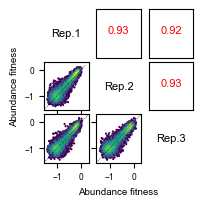

In [18]:
### Biological replicate correlations ###

from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Arial'

core_variants = allvariants_scaled.loc[allvariants_scaled['library']=='Ad-hoc_full_core'].copy()
core_variants.to_csv(path+'Fig5/FYN_core_randomization_fitness_replicates.txt',sep='\t',index=False)
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('{:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center', size = 8, color='red')
    ax.tick_params(right=False, top=False, left=False, bottom=False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    #ax.tick_params(axis='both', which='major', labelsize=14)
def replicate(x,**kwargs):
    ax = plt.gca()
    ax.text(.5,.5,'Rep.'+x.name[7:8],size=8,ha='center',va='center', transform=ax.transAxes)
    ax.set_axis_off()
def hexbin(x, y, color, **kwargs): #https://stackoverflow.com/questions/40495093/hexbin-plot-in-pairgrid-with-seaborn
    ax = plt.gca()
    cmap = sns.color_palette('viridis', as_cmap=True)
    ax.hexbin(x, y, bins='log',gridsize=50, cmap=cmap, extent=[min(x), max(x), min(y), max(y)], **kwargs, rasterized=True)
    lims = np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])
    plt.plot(lims, lims, '--', color='k', linewidth=0.3)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.set_ylim(-1.55,0.3)
    ax.set_xlim(-1.55,0.3)
    ax.set_xticks(np.arange(-1,1,1))
    ax.set_yticks(np.arange(-1,1,1))
    ax.tick_params(axis='both', which='major', labelsize=6)

g = sns.PairGrid(core_variants[['fitness1_uncorr', 'fitness2_uncorr', 'fitness3_uncorr']].dropna())
g.map_upper(reg_coef, hue=None)
g.map_diag(replicate)
g.map_lower(hexbin)
g.fig.set_size_inches(1.7,1.7)

for i in range(3):
    g.axes[i, i].set_visible(False)

for ax in g.axes.flatten():
    if ax.get_xlabel() != '':
        if str(ax.get_xlabel().split('_')[0][-1]) == '1' or str(ax.get_xlabel().split('_')[0][-1]) == '3':
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Abundance fitness', fontsize=7)
    if ax.get_ylabel() != '':
        if str(ax.get_ylabel().split('_')[0][-1]) == '1' or str(ax.get_ylabel().split('_')[0][-1]) == '3':
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Abundance fitness', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('RandFYN_corelayer_Fitness_correl.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel D

In [19]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    #cm.register_cmap(cmap=newcmap)
    matplotlib.colormaps.register(cmap=newcmap)

    return newcmap
iterator_cmap = 1

In [20]:
import pandas as pd
from collections import defaultdict

def find_one_char_diff_pairs(df, column_name):
    strings = df[column_name].tolist()

    result = {string: [] for string in strings}

    def generate_partial_strings(s):
        partials = []
        for i in range(len(s)):
            partials.append(s[:i] + "_" + s[i+1:])
        return partials

    partial_dict = defaultdict(list)

    for string in strings:
        partials = generate_partial_strings(string)
        for partial in partials:
            partial_dict[partial].append(string)

    for string in strings:
        partials = generate_partial_strings(string)
        for partial in partials:
            for match in partial_dict[partial]:
                if match != string:
                    result[string].append(match)

    return result


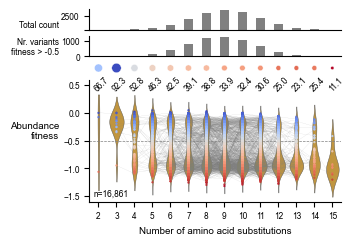

In [21]:
import seaborn as sns
import networkx as nx
from itertools import count
from seaborn import kdeplot
from itertools import groupby
import matplotlib
import numpy as np

dod = find_one_char_diff_pairs(core_variants, 'aa_seq')

nr_core_variants = 1492992

lowest_nham=int(core_variants.sort_values('real_Nham_aa', ascending=True).iloc[0]['real_Nham_aa'])
highest_nham=int(core_variants.sort_values('real_Nham_aa', ascending=False).iloc[0]['real_Nham_aa'])

total_core_viabilities = pd.DataFrame(columns=['protein', 'variants_above_01', 'variants_above_025', 'variants_above_05', 'variants_below_05'])
    
G = nx.from_dict_of_lists(dod)

pos={}
for index, row in core_variants.iterrows():
    pos[row.aa_seq] = (row.real_Nham_aa-lowest_nham, row.fitness)
    

fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,1,12],'hspace': 0.15},figsize=(3.25,2.5))
plt.close()
fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,1,12],'hspace': 0.15},figsize=(3.25,2.5),sharex=ax1)

or2 = core_variants[core_variants['real_Nham_aa']==2]
rest = core_variants[core_variants['real_Nham_aa']!=2]
sns.violinplot(x="real_Nham_aa", y="fitness", data=or2, inner=None, ax=ax2, color='#D59C2A', linewidth=0.3,cut=0.7, width=0.1)
sns.violinplot(x="real_Nham_aa", y="fitness", data=rest, inner=None, ax=ax2, color='#D59C2A', linewidth=0.3)

plt.axhline(y=-0.5, linestyle='--', color='gray', linewidth=0.5)

remove=[i for i in dod.keys() if i not in pos.keys()]

G.remove_nodes_from(remove)

fitness_values=[]
for i in pos:
    fitness_values.append(pos[i][1])
groups = []
for _, g in groupby(fitness_values, lambda x: (x-1)//0.05):
    groups.append(list(g))      # Store group iterator as a list

fitness_attr={}
for node in G.nodes:
    iterator=0
    for bin in groups:
        if pos[node][1] in bin:
            fitness_attr[node]=iterator
            break
        iterator+=1

nx.set_node_attributes(G, fitness_attr, 'fitness')
groups = set(nx.get_node_attributes(G,'fitness').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['fitness']] for n in nodes]

total_viable=0
nham_viability=pd.DataFrame(columns=['Number_of_variants','Fraction_50pc_folded'])
nham_viability['protein']=pd.Series(dtype="object") 
for nham in range(lowest_nham,highest_nham+1,1):
    nham_viability.at[nham,'protein']='FYN'
    nham_viability.at[nham,'nham']=nham
    nham_viability.at[nham,'Number_of_variants']=len(core_variants.loc[core_variants['real_Nham_aa']==nham])
    nham_viability.at[nham,'Fraction_50pc_folded']=round(100*(len(core_variants.loc[core_variants['real_Nham_aa']==nham].loc[core_variants['fitness']>=-0.5].index)/len(core_variants.loc[core_variants['real_Nham_aa']==nham])),1)
    nham_viability.at[nham,'Number_of_50pc_folded_variants']=len(core_variants.loc[core_variants['real_Nham_aa']==nham].loc[core_variants['fitness']>=-0.5].index)
    nham_viability.at[nham,'Fraction_75pc_folded']=round(100*(len(core_variants.loc[core_variants['real_Nham_aa']==nham].loc[core_variants['fitness']>=-0.25].index)/len(core_variants.loc[core_variants['real_Nham_aa']==nham])),1)
    nham_viability.at[nham,'Number_of_75pc_folded_variants']=len(core_variants.loc[core_variants['real_Nham_aa']==nham].loc[core_variants['fitness']>=-0.25].index)
    nham_viability.at[nham,'Fraction_90pc_folded']=round(100*(len(core_variants.loc[core_variants['real_Nham_aa']==nham].loc[core_variants['fitness']>=-0.1].index)/len(core_variants.loc[core_variants['real_Nham_aa']==nham])),1)
    nham_viability.at[nham,'Number_of_90pc_folded_variants']=len(core_variants.loc[core_variants['real_Nham_aa']==nham].loc[core_variants['fitness']>=-0.1].index)
    total_viable=total_viable+len(core_variants.loc[core_variants['real_Nham_aa']==nham].loc[core_variants['fitness']>=-0.5].index)
for index, row in nham_viability.iterrows():
    nham_viability.at[index,'Fraction_of_total_50pc_viable_variants']= round(100*row['Number_of_50pc_folded_variants']/total_viable,1)

total_core_viabilities.at['core','variants_above_01']=len(core_variants.loc[core_variants['fitness']>=-0.1].index)/len(core_variants.index)*nr_core_variants
total_core_viabilities.at['core','variants_above_025']=len(core_variants.loc[core_variants['fitness']>=-0.25].index)/len(core_variants.index)*nr_core_variants
total_core_viabilities.at['core','variants_below_05']=5**7-len(core_variants.loc[core_variants['fitness']>=-0.5].index)/len(core_variants.index)*nr_core_variants
total_core_viabilities.at['core','variants_above_05']=len(core_variants.loc[core_variants['fitness']>=-0.5].index)/len(core_variants.index)*nr_core_variants
    
orig_cmap = plt.cm.coolwarm
iterator_cmap+=1
midpoint=(-0.5 - np.min(core_variants['fitness']))/ (np.max(core_variants['fitness']) - np.min(core_variants['fitness']))
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=1-midpoint, name='shifted'+str(iterator_cmap))
    
nx.draw_networkx(G, pos=pos, with_labels=False, node_size=0, ax=ax2, edge_color='gray', width=0.05)
nodes=nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, node_size=0.3, cmap=shifted_cmap)
ax2.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax2.set_xlabel('Number of amino acid substitutions', fontsize=7)
ax2.set_ylabel("Abundance\nfitness", fontsize=7,rotation='horizontal', ha='right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=6)

nham_viability['Fraction_50pc_folded'] = pd.to_numeric(nham_viability['Fraction_50pc_folded'], errors='coerce')
sns.scatterplot(x=[i-lowest_nham for i in nham_viability['nham']],y=[0]*len(nham_viability.index), hue=nham_viability['Fraction_50pc_folded'],palette='coolwarm_r', s=nham_viability['Fraction_50pc_folded']*0.5, legend=False,ax=ax1)
ax1.spines[['top','right','left','bottom']].set_visible(False)
ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False,top=False, right=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
for index, row in nham_viability.iterrows():
    if row.Fraction_50pc_folded == 100.0:
        ax2.annotate(100, (row.nham-lowest_nham-0.4,0.4), fontsize=6, color='black', rotation=45)
    else:
        ax2.annotate(row.Fraction_50pc_folded, (row.nham-lowest_nham-0.3,0.4), fontsize=6, color='black', rotation=45)
#ax1.set_ylabel('% variants\nfitness > -0.5',fontsize=6,rotation='horizontal', ha='right')
        
ax2.annotate('n='+f"{len(core_variants):,}", (-0.3,-1.5), fontsize=6)
plt.subplots_adjust(hspace=0.05)

nham_viability['Number_of_variants'].plot.bar(ax=ax0,fontsize=6,color='gray')
ax0.spines[['top','right']].set_visible(False)
ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax0.set_ylabel('Total count',fontsize=6, rotation='horizontal', ha='right')
ticks = ax0.get_yticks()
new_ticks = ticks[:-1]
ax0.set_yticks(new_ticks)
ticks = ax0.get_yticks()
labels = [label.get_text() for label in ax0.get_yticklabels()]
labels[0]= ""

ax0.set_yticks(ticks)
ax0.set_yticklabels(labels)

nham_viability['Number_of_50pc_folded_variants'].plot.bar(ax=axviable,fontsize=6,color='gray')
axviable.spines[['top','right']].set_visible(False)
axviable.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axviable.set_ylabel('Nr. variants\nfitness > -0.5',fontsize=6,rotation='horizontal', ha='right')

labeloffset= -0.12
ax0.get_yaxis().set_label_coords(labeloffset,0)
axviable.get_yaxis().set_label_coords(labeloffset,0)
ax1.get_yaxis().set_label_coords(labeloffset,-1)
ax2.get_yaxis().set_label_coords(labeloffset,0.5)
plt.ylim(-1.6,0.6)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('RandFYN_corelayer_fitness_distris.png', dpi=300, transparent=True, bbox_inches='tight')

## Panel E

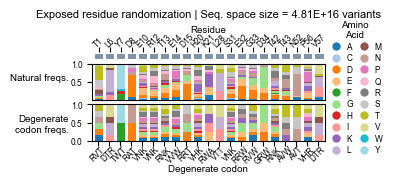

In [22]:
import math

plt.rcParams['font.family'] = 'Arial'

mut_pos_surf = np.where(sorted_res_categories == 2)[0].tolist()

real_mut_pos_surf = [j+1 for j in mut_pos_surf]
surf_array = np.array([0 for pos in real_mut_pos_surf])

core_frac_df = frac_df.T.loc[[i+1 for i in mut_pos_surf]]
surface_deg_cod = deg_codons_df.T.copy()
surface_deg_cod = surface_deg_cod.reset_index(drop=False)
surface_deg_cod.index +=1
surface_deg_cod = surface_deg_cod.loc[[i+1 for i in mut_pos_surf]]
surface_deg_cod.index = surface_deg_cod['index']
surface_deg_cod

new_colors = ['#8294A7']
new_cmap_2 = ListedColormap(new_colors)

fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'
fig = plt.figure(figsize=(3, 1))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 5, 5], hspace=0.15)

ax_sequence = fig.add_subplot(gs[0, 0])
ax_natural_freqs = fig.add_subplot(gs[1, 0])
ax_deg_codons = fig.add_subplot(gs[2, 0])

core_frac_df.plot(kind='bar', stacked=True, legend=False, ax=ax_natural_freqs, cmap='tab20')
ax_natural_freqs.set_yticks(np.arange(0.5, 1.2, 0.5))
ax_natural_freqs.set_yticklabels(np.arange(0.5, 1.2, 0.5), fontsize=6)
ax_natural_freqs.set_ylabel('Natural freqs.', fontsize=7, rotation=0, labelpad=-10)
ax_natural_freqs.yaxis.label.set_ha("right")
ax_natural_freqs.yaxis.set_label_coords(-0.1, 0.5) 
ax_natural_freqs.yaxis.tick_left()
ax_natural_freqs.set_ylim(0, 1)
ax_natural_freqs.set_xticks([])

surface_deg_cod.plot(kind='bar', stacked=True, cmap='tab20', ax=ax_deg_codons, legend=False)
ax_deg_codons.set_yticks(np.arange(0, 1.2, 0.5))
ax_deg_codons.set_yticklabels(np.arange(0, 1.2, 0.5), fontsize=6)
ax_deg_codons.set_ylabel('\nDegenerate\ncodon freqs.', fontsize=7, rotation=0, labelpad=-10)
ax_deg_codons.yaxis.label.set_ha("right")
ax_deg_codons.yaxis.set_label_coords(-0.1, 0.2) 
ax_deg_codons.yaxis.tick_left()
ax_deg_codons.set_ylim(0, 1)
ax_deg_codons.set_xticklabels([i.get_text().split('_')[1] for i in ax_deg_codons.get_xticklabels()], fontsize=6, rotation=45)
ax_deg_codons.tick_params(axis='x', pad=-1)
ax_deg_codons.set_xlabel('Degenerate codon', fontsize=7, labelpad=-1)

for container in ax_natural_freqs.containers + ax_deg_codons.containers:
    for bar in container:
        bar.set_width(0.75)
heatmap = sns.heatmap(
    surf_array.reshape(1, len(mut_pos_surf)), cmap=new_cmap_2, norm=norm,
    cbar=False, linewidths=1, linecolor='white', square=False, ax=ax_sequence
)
ax_sequence.set_yticks([])
ax_sequence.set_xticks(np.arange(0.5,len(mut_pos_surf),1))
ax_sequence.set_xticklabels([fyn_wt[i]+str(i+1) for i in mut_pos_surf], fontsize=6)
ax_sequence.xaxis.set_ticks_position("top")
ax_sequence.xaxis.set_label_position("top")
ax_sequence.tick_params(axis='x', rotation=45, pad=-1)
ax_sequence.set_xlabel('Residue',fontsize=7, labelpad=-1)

ax_natural_freqs.set_xlim(-0.5, len(core_frac_df)-0.4)
ax_deg_codons.set_xlim(-0.5, len(core_frac_df)-0.4)
ax_sequence.set_xlim(-0.1,len(surf_array))

handles, labels = ax_deg_codons.get_legend_handles_labels()
legend_columns = [core_frac_df[column].name for column in core_frac_df.columns if core_frac_df[column].sum() > 0]
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l in legend_columns]
filtered_handles, filtered_labels = zip(*filtered_handles_labels) if filtered_handles_labels else ([], [])
filtered_handles_circles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=h.patches[0].get_facecolor(), markersize=6, markeredgewidth=0)
    for h in filtered_handles
]
legend = fig.legend(
    filtered_handles_circles, filtered_labels, loc="center left", bbox_to_anchor=(0.89, 0.65),  # Position at right center
    fontsize=6, handletextpad=0.3, columnspacing=0.3, labelspacing=0.3, ncol=2,
    borderpad=0.2, frameon=False, title='Amino\nAcid'
)
legend.get_title().set_fontsize(7)
legend.get_title().set_ha('center')

for ax in [ax_natural_freqs, ax_deg_codons]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.8)

res_per_pos =[]
for column in surface_deg_cod.drop('index',axis=1).T.columns:
    res_per_pos.append(surface_deg_cod.drop('index',axis=1).T[column].count())

ax_sequence.set_title('Exposed residue randomization | Seq. space size = ' + str("{:.2E}".format(math.prod(res_per_pos))) + ' variants', fontsize=8)

fig.subplots_adjust(hspace=1, wspace= 0.05,top=1)

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Surface_mutagenesis_design.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel F

In [23]:
surface_variants = allvariants_scaled[allvariants_scaled['library'].isin(['Ad-hoc_full_surface', 'Ad-hoc_surface_half1', 'Ad-hoc_surface_half2'])].copy()

### Filter out misassigned variants ###

for index, row in surface_deg_cod.iterrows():
    surface_deg_cod.at[index,'pos']=int(row['index'][:-4])

surface_deg_cod['pos']=surface_deg_cod['pos'].astype(int)
surface_deg_cod=surface_deg_cod.drop('index',axis=1)
surface_deg_cod=surface_deg_cod.set_index('pos',drop=True)
surface_deg_cod=surface_deg_cod.fillna(0)

def find_unallowed_mutations(surface_variants, surface_deg_cod, fyn_wt):
    unallowed_list = []

    for _, row in surface_variants.iterrows():
        aa_seq = row['aa_seq']
        unallowed_mutations = []

        for pos in surface_deg_cod.index:
            wt_aa = fyn_wt[pos - 1]
            current_aa = aa_seq[pos - 1]

            if surface_deg_cod.loc[pos, current_aa] == 0:
                unallowed_mutations.append(f"{wt_aa}{pos}{current_aa}")

        unallowed_list.append(",".join(unallowed_mutations))

    surface_variants['unallowed_mutations'] = unallowed_list
    return surface_variants

surface_variants = find_unallowed_mutations(surface_variants, surface_deg_cod, fyn_wt)
surface_variants = surface_variants.loc[surface_variants['unallowed_mutations']==''].copy()
surface_variants.to_csv(path+'Fig5/FYN_surface_randomization_fitness_replicates.txt',sep='\t',index=False)

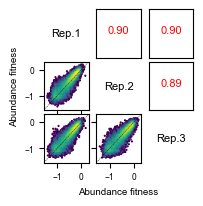

In [24]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('{:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center', size = 8, color='red')
    ax.tick_params(right=False, top=False, left=False, bottom=False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    #ax.tick_params(axis='both', which='major', labelsize=14)
def replicate(x,**kwargs):
    ax = plt.gca()
    ax.text(.5,.5,'Rep.'+x.name[7:8],size=8,ha='center',va='center', transform=ax.transAxes)
    ax.set_axis_off()
def hexbin(x, y, color, **kwargs): #https://stackoverflow.com/questions/40495093/hexbin-plot-in-pairgrid-with-seaborn
    ax = plt.gca()
    cmap = sns.color_palette('viridis', as_cmap=True)
    ax.hexbin(x, y, bins='log',gridsize=50, cmap=cmap, extent=[min(x), max(x), min(y), max(y)], **kwargs, rasterized=True)
    lims = np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])
    plt.plot(lims, lims, '--', color='k', linewidth=0.3)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.set_ylim(-1.55,0.3)
    ax.set_xlim(-1.55,0.3)
    ax.set_xticks(np.arange(-1,1,1))
    ax.set_yticks(np.arange(-1,1,1))
    ax.tick_params(axis='both', which='major', labelsize=6)

g = sns.PairGrid(surface_variants[['fitness1_uncorr', 'fitness2_uncorr', 'fitness3_uncorr']].dropna())
g.map_upper(reg_coef, hue=None)
g.map_diag(replicate)
g.map_lower(hexbin)
g.fig.set_size_inches(1.7,1.7)

for i in range(3):
    g.axes[i, i].set_visible(False)

for ax in g.axes.flatten():
    if ax.get_xlabel() != '':
        if str(ax.get_xlabel().split('_')[0][-1]) == '1' or str(ax.get_xlabel().split('_')[0][-1]) == '3':
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Abundance fitness', fontsize=7)
    if ax.get_ylabel() != '':
        if str(ax.get_ylabel().split('_')[0][-1]) == '1' or str(ax.get_ylabel().split('_')[0][-1]) == '3':
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Abundance fitness', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('RandFYN_surface_alldata_Fitness_correl.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel G

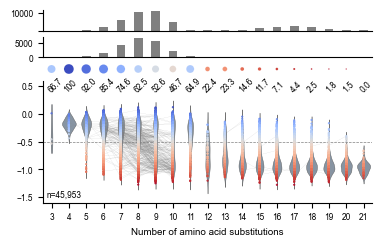

In [25]:
import seaborn as sns
import networkx as nx
from itertools import count
from seaborn import kdeplot
from itertools import groupby
import matplotlib
import numpy as np

dod = find_one_char_diff_pairs(surface_variants, 'aa_seq')

lowest_nham=int(surface_variants.sort_values('real_Nham_aa', ascending=True).iloc[0]['real_Nham_aa'])
highest_nham=int(surface_variants.sort_values('real_Nham_aa', ascending=False).iloc[0]['real_Nham_aa'])

total_core_viabilities = pd.DataFrame(columns=['protein', 'variants_above_01', 'variants_above_025', 'variants_above_05', 'variants_below_05'])
    
G = nx.from_dict_of_lists(dod)

pos={}
for index, row in surface_variants.iterrows():
    pos[row.aa_seq] = (row.real_Nham_aa-lowest_nham, row.fitness)
    

fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,1,12],'hspace': 0.15},figsize=(4.25,2.5))
plt.close()
fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,1,12],'hspace': 0.15},figsize=(4.25,2.5),sharex=ax1)

or2 = surface_variants[surface_variants['real_Nham_aa']==3]
rest = surface_variants[surface_variants['real_Nham_aa']!=3]
sns.violinplot(x="real_Nham_aa", y="fitness", data=or2, inner=None, ax=ax2, color='#8294A7', linewidth=0.3,cut=0.7, width=0.1)
sns.violinplot(x="real_Nham_aa", y="fitness", data=rest, inner=None, ax=ax2, color='#8294A7', linewidth=0.3)
#fig=sns.violinplot(x="real_Nham_aa", y="fitness", data=surface_variants, inner=None, ax=ax2, color='#8294A7', linewidth=0.3)
plt.axhline(y=-0.5, linestyle='--', color='gray', linewidth=0.5)

remove=[i for i in dod.keys() if i not in pos.keys()]

G.remove_nodes_from(remove)

fitness_values=[]
for i in pos:
    fitness_values.append(pos[i][1])
groups = []
for _, g in groupby(fitness_values, lambda x: (x-1)//0.05):
    groups.append(list(g))      # Store group iterator as a list

fitness_attr={}
for node in G.nodes:
    iterator=0
    for bin in groups:
        if pos[node][1] in bin:
            fitness_attr[node]=iterator
            break
        iterator+=1

nx.set_node_attributes(G, fitness_attr, 'fitness')
groups = set(nx.get_node_attributes(G,'fitness').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['fitness']] for n in nodes]

total_viable=0
nham_viability=pd.DataFrame(columns=['Number_of_variants','Fraction_50pc_folded'])
nham_viability['protein']=pd.Series(dtype="object") 
for nham in range(lowest_nham,highest_nham+1,1):
    nham_viability.at[nham,'protein']='FYN'
    nham_viability.at[nham,'nham']=nham
    nham_viability.at[nham,'Number_of_variants']=len(surface_variants.loc[surface_variants['real_Nham_aa']==nham])
    nham_viability.at[nham,'Fraction_50pc_folded']=round(100*(len(surface_variants.loc[surface_variants['real_Nham_aa']==nham].loc[surface_variants['fitness']>=-0.5].index)/len(surface_variants.loc[surface_variants['real_Nham_aa']==nham])),1)
    nham_viability.at[nham,'Number_of_50pc_folded_variants']=len(surface_variants.loc[surface_variants['real_Nham_aa']==nham].loc[surface_variants['fitness']>=-0.5].index)
    nham_viability.at[nham,'Fraction_75pc_folded']=round(100*(len(surface_variants.loc[surface_variants['real_Nham_aa']==nham].loc[surface_variants['fitness']>=-0.25].index)/len(surface_variants.loc[surface_variants['real_Nham_aa']==nham])),1)
    nham_viability.at[nham,'Number_of_75pc_folded_variants']=len(surface_variants.loc[surface_variants['real_Nham_aa']==nham].loc[surface_variants['fitness']>=-0.25].index)
    nham_viability.at[nham,'Fraction_90pc_folded']=round(100*(len(surface_variants.loc[surface_variants['real_Nham_aa']==nham].loc[surface_variants['fitness']>=-0.1].index)/len(surface_variants.loc[surface_variants['real_Nham_aa']==nham])),1)
    nham_viability.at[nham,'Number_of_90pc_folded_variants']=len(surface_variants.loc[surface_variants['real_Nham_aa']==nham].loc[surface_variants['fitness']>=-0.1].index)
    total_viable=total_viable+len(surface_variants.loc[surface_variants['real_Nham_aa']==nham].loc[surface_variants['fitness']>=-0.5].index)
for index, row in nham_viability.iterrows():
    nham_viability.at[index,'Fraction_of_total_50pc_viable_variants']= round(100*row['Number_of_50pc_folded_variants']/total_viable,1)

total_core_viabilities.at['core','variants_above_01']=len(surface_variants.loc[surface_variants['fitness']>=-0.1].index)/len(surface_variants.index)*5**7
total_core_viabilities.at['core','variants_above_025']=len(surface_variants.loc[surface_variants['fitness']>=-0.25].index)/len(surface_variants.index)*5**7
total_core_viabilities.at['core','variants_below_05']=5**7-len(surface_variants.loc[surface_variants['fitness']>=-0.5].index)/len(surface_variants.index)*5**7
total_core_viabilities.at['core','variants_above_05']=len(surface_variants.loc[surface_variants['fitness']>=-0.5].index)/len(surface_variants.index)*5**7
    
orig_cmap = plt.cm.coolwarm
iterator_cmap+=1
midpoint=(-0.5 - np.min(surface_variants['fitness']))/ (np.max(surface_variants['fitness']) - np.min(surface_variants['fitness']))
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=1-midpoint, name='shifted'+str(iterator_cmap))
    
nx.draw_networkx(G, pos=pos, with_labels=False, node_size=0, ax=ax2, edge_color='gray', width=0.05)
nodes=nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, node_size=0.3, cmap=shifted_cmap)
ax2.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax2.set_xlabel('Number of amino acid substitutions', fontsize=7)
#ax2.set_ylabel("Abundance\nfitness", fontsize=7,rotation='horizontal', ha='right')
ax2.set_ylabel("", fontsize=7,rotation='horizontal', ha='right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=6)

nham_viability['Fraction_50pc_folded'] = pd.to_numeric(nham_viability['Fraction_50pc_folded'], errors='coerce')
sns.scatterplot(x=[i-lowest_nham for i in nham_viability['nham']],y=[0]*len(nham_viability.index), hue=nham_viability['Fraction_50pc_folded'],palette='coolwarm_r', s=nham_viability['Fraction_50pc_folded']*0.5, legend=False,ax=ax1)
#ax1.legend_.remove()
ax1.spines[['top','right','left','bottom']].set_visible(False)
ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False,top=False, right=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
for index, row in nham_viability.iterrows():
    if row.Fraction_50pc_folded == 100.0:
        ax2.annotate(100, (row.nham-lowest_nham-0.4,0.4), fontsize=6, color='black', rotation = 45)
    else:
        ax2.annotate(row.Fraction_50pc_folded, (row.nham-lowest_nham-0.3,0.4), fontsize=6, color='black', rotation=45)
#ax1.set_ylabel('% variants\nfitness > -0.5',fontsize=6,rotation='horizontal', ha='right')
        
ax2.annotate('n='+f"{len(surface_variants):,}", (-0.3,-1.5), fontsize=6)
plt.subplots_adjust(hspace=0.05)

nham_viability['Number_of_variants'].plot.bar(ax=ax0,fontsize=6,color='gray')
ax0.spines[['top','right']].set_visible(False)
ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#ax0.set_ylabel('Total count',fontsize=6, rotation='horizontal', ha='right')
ax0.set_ylabel('',fontsize=6, rotation='horizontal', ha='right')
ticks = ax0.get_yticks()
new_ticks = ticks[:-1]
ax0.set_yticks(new_ticks)
ticks = ax0.get_yticks()
labels = [label.get_text() for label in ax0.get_yticklabels()]
labels[0]= ""

ax0.set_yticks(ticks)
ax0.set_yticklabels(labels)

nham_viability['Number_of_50pc_folded_variants'].plot.bar(ax=axviable,fontsize=6,color='gray')
axviable.spines[['top','right']].set_visible(False)
axviable.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#axviable.set_ylabel('Nr. variants\nfitness > -0.5',fontsize=6,rotation='horizontal', ha='right')
axviable.set_ylabel('',fontsize=6,rotation='horizontal', ha='right')

labeloffset= -0.12
ax0.get_yaxis().set_label_coords(labeloffset,0)
axviable.get_yaxis().set_label_coords(labeloffset,0)
ax1.get_yaxis().set_label_coords(labeloffset,-1)
ax2.get_yaxis().set_label_coords(labeloffset,0.5)
plt.ylim(-1.6,0.6)
#plt.xlim(-0.5,7-lowest_nham+0.5)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('RandFYN_surface_alldata_fitness_distris.png', dpi=300, transparent=True, bbox_inches='tight')

## Panel H

In [26]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math
import seaborn as sns
import pandas as pd

quantile = 0.8

fyn_overall_full_model_performance = pd.DataFrame()
fyn_model_performance_by_nham=pd.DataFrame()
fyn_overall_sparse_model_performance=pd.DataFrame()
fyn_sparse_model_performance_by_nham=pd.DataFrame()

model_names = {'1_linear': 'Linear', '1':'1', '2':'2', '2_sparse_regularized':'2'}
tasks = {'1_linear': '1', '1':'1', '2':'1', '2_sparse_regularized':'4'}

for mochi_model in model_names.keys():

    # Load predictions
    predicted_phenotypes = pd.read_csv(path+'Fig5/mochi/Core/RandomFYN_core_order'+mochi_model+'/task_'+tasks[mochi_model]+'/predictions/predicted_phenotypes_all.txt',
                                      sep='\t', lineterminator='\n', low_memory=False)
    
    RT=303*0.001987
    predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
    predicted_phenotypes['std_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].std(axis=1)
    
    predicted_phenotypes['mean']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].mean(axis=1)
    predicted_phenotypes['std']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].std(axis=1)
    
    predicted_phenotypes['mean_dG']= predicted_phenotypes['mean_additive_trait']*RT
    predicted_phenotypes['std_dG']= predicted_phenotypes['std_additive_trait']*RT
    
    for index, row in predicted_phenotypes.loc[predicted_phenotypes['WT']!=True].iterrows():
        predicted_phenotypes.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
        predicted_phenotypes.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

    predicted_phenotypes_scaled = predicted_phenotypes[predicted_phenotypes['sigma'] <= predicted_phenotypes['sigma'].quantile(quantile)].copy()

    # calculate overall performance
    y = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']>0][['fitness']].to_numpy()
    x = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']>0][['predicted_fitness']].to_numpy()
    model = LinearRegression()
    model.fit(x,y)
    y_pred = model.predict(x)

    if mochi_model != '2_sparse_regularized':
        fyn_overall_full_model_performance.at[model_names[mochi_model],'All']=round(r2_score(y,y_pred),2)
    else:
        fyn_overall_sparse_model_performance.at[model_names[mochi_model],'All']=round(r2_score(y,y_pred),2)

    # calculate performance per nham
    for hamm_dist in range(2,16,1):    
        y = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']==hamm_dist][['fitness']].to_numpy()
        x = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']==hamm_dist][['predicted_fitness']].to_numpy()
        
        model = LinearRegression()
        model.fit(x,y)
        y_pred = model.predict(x)
        
        if mochi_model != '2_sparse_regularized':
            fyn_model_performance_by_nham.at[model_names[mochi_model],hamm_dist]=round(r2_score(y,y_pred),2)
        else:
            fyn_sparse_model_performance_by_nham.at[model_names[mochi_model],hamm_dist]=round(r2_score(y,y_pred),2)

predicted_phenotypes = pd.read_csv(path+'Fig5/mochi/Core/RandomFYN_core_order1/task_1/predictions/predicted_phenotypes_all.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

predicted_phenotypes=predicted_phenotypes[predicted_phenotypes['sigma'] <= predicted_phenotypes['sigma'].quantile(0.8)].copy()

cummulative_sigma = 0
for index, row in predicted_phenotypes.iterrows():
    cummulative_sigma = cummulative_sigma + (row.sigma**2)

MEV = predicted_phenotypes.var(numeric_only=True)['fitness'] - (cummulative_sigma/len(predicted_phenotypes.index))
all_order_FEV = MEV/predicted_phenotypes.var(numeric_only=True)['fitness']

FEV_correction = pd.DataFrame()
for nham in range(2,16,1):
    nham_vars = predicted_phenotypes.loc[predicted_phenotypes['Nham_aa']==nham]
    
    cummulative_sigma = 0
    for index, row in nham_vars.iterrows():
        cummulative_sigma = cummulative_sigma + (row.sigma**2)
    
    MEV = nham_vars.var(numeric_only=True)['fitness'] - (cummulative_sigma/len(nham_vars.index))
    FEV = MEV/nham_vars.var(numeric_only=True)['fitness']
    FEV_correction.at[0,nham]=FEV

full_models_terms_by_order = pd.DataFrame(index=np.arange(1,3,1))

models = {'1_linear':'Linear',
         '1':'1',
         '2':'2'}

for model in models.keys():
    coefs = pd.read_csv(path+'Fig5/mochi/Core/RandomFYN_core_order'+model+'/task_1/weights/weights_Folding.txt',
                       sep='\t')
    coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        coefs.at[index,'order']=len(row.id.split('_'))
    full_models_terms_by_order[models[model]]=coefs['order'].value_counts()

sparse_models_terms_by_order = pd.DataFrame(index=np.arange(1,3,1))

for order in range(2,3,1):
    coefs = pd.read_csv(path+'Fig5/mochi/Core/RandomFYN_core_order'+str(order)+'_sparse_regularized/task_4/weights/weights_Folding.txt',
                       sep='\t')
    coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        coefs.at[index,'order']=len(row.id.split('_'))
    sparse_models_terms_by_order[order]=coefs['order'].value_counts()

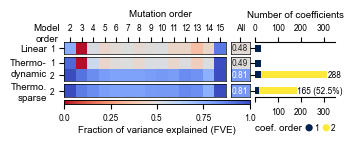

In [27]:
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

fig, ax = plt.subplot_mosaic([['top left', 'top centre', 'top right'],
                              ['biophys left', 'biophys centre', 'biophys right'],
                              ['middle left', 'middle centre', 'middle right'],
                              ['bottom left-centre', 'bottom left-centre', 'bottom right']],
                            width_ratios = [6, 0.7, 3],
                            height_ratios = [0.33, 0.67 ,0.37,0.1],
                            figsize=(3.5,0.8))

sns.heatmap(fyn_model_performance_by_nham.iloc[0:1].divide(FEV_correction.loc[0],axis=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['top left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
sns.heatmap(fyn_model_performance_by_nham.iloc[1:].divide(FEV_correction.loc[0],axis=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['biophys left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
sns.heatmap(fyn_sparse_model_performance_by_nham.divide(FEV_correction.loc[0],axis=1).apply(pd.to_numeric), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['middle left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5,cbar_ax=ax['bottom left-centre'],cbar_kws={"orientation": "horizontal", 'location':'bottom'})

ax['top left'].set_xticks([i+0.5 for i in range(fyn_model_performance_by_nham.shape[1])])
ax['top left'].set_xticklabels(fyn_model_performance_by_nham.columns, fontsize=6, rotation=0)
ax['top left'].set_yticks([0.5])
ax['top left'].set_yticklabels(['1'], fontsize=6, rotation=0)
ax['top left'].xaxis.set_label_position('top')
ax['top left'].xaxis.set_ticks_position('top')
ax['top left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['middle left'].set_yticks([i+0.5 for i in range(fyn_sparse_model_performance_by_nham.shape[0])])
ax['middle left'].set_yticklabels([str(i+2) for i in range(fyn_sparse_model_performance_by_nham.shape[0])], fontsize=6, rotation=0)
ax['middle left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['middle left'].set_xticks(ticks=[])
ax['biophys left'].set_yticks([i+0.5 for i in range(fyn_model_performance_by_nham.shape[0]-1)])
ax['biophys left'].set_yticklabels([str(i+1) for i in range(fyn_model_performance_by_nham.shape[0]-1)], fontsize=6, rotation=0)
ax['biophys left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['biophys left'].set_xticks(ticks=[])
ax['bottom left-centre'].set_xticks(ticks=np.arange(0,1.25,.25),labels=np.arange(0,1.25,.25), fontsize=6)
ax['bottom left-centre'].set_xlabel('Fraction of variance explained (FVE)', rotation=0, labelpad=2, fontsize=7)

sns.heatmap(fyn_overall_full_model_performance.iloc[0:1]/all_order_FEV, annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['top centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['top centre'].set_yticks(ticks=[])
ax['top centre'].set_xticks([i+0.5 for i in range(fyn_overall_full_model_performance.shape[1])])
ax['top centre'].set_xticklabels(fyn_overall_full_model_performance.columns, fontsize=6, rotation=0)
ax['top centre'].xaxis.set_label_position('top')
ax['top centre'].xaxis.set_ticks_position('top')
ax['top centre'].tick_params(axis='both',labelsize=6, labelrotation=0)

sns.heatmap((fyn_overall_full_model_performance.iloc[1:]/all_order_FEV), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['biophys centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['biophys centre'].set_yticks(ticks=[])
ax['biophys centre'].set_xticks(ticks=[])

sns.heatmap((fyn_overall_sparse_model_performance/all_order_FEV), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['middle centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['middle centre'].set_yticks(ticks=[])
ax['middle centre'].set_xticks(ticks=[])

full_models_terms_by_order.T.iloc[0:1].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['top right'], legend=False, width=0.65)
ax['top right'].invert_yaxis()
ax['top right'].spines[['right','bottom','left']].set_visible(False)
ax['top right'].xaxis.set_label_position('top')
ax['top right'].xaxis.set_ticks_position('top')
ax['top right'].set_xlabel('Number of coefficients', fontsize=7)
ax['top right'].set_yticks(ticks=np.arange(0,1,1), labels=[])
ax['top right'].set_xticks(ticks=np.arange(0,400,100),labels=np.arange(0,400,100))
ax['top right'].set_xlim(0,350)
ax['top right'].tick_params(axis='both',labelsize=6, labelrotation=0)

full_models_terms_by_order.T.iloc[1:].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['biophys right'], legend=False, width=0.65)
ax['biophys right'].invert_yaxis()
ax['biophys right'].spines[['right','bottom','left','top']].set_visible(False)
ax['biophys right'].set_yticks(ticks=np.arange(0,2,1), labels=[])
ax['biophys right'].set_xticks(ticks=[],labels=[])
ax['biophys right'].set_xlim(0,350)
ax['biophys right'].tick_params(axis='both',labelsize=6, labelrotation=0)

sparse_models_terms_by_order.T.plot(kind='barh', stacked=True, cmap='cividis', ax=ax['middle right'], legend=False, width=0.6)
ax['middle right'].invert_yaxis()
handles, labels = ax['middle right'].get_legend_handles_labels()
ax['middle right'].spines[['right','top','left']].set_visible(False)
ax['middle right'].set_yticks(ticks=np.arange(0,1,1),labels=[])
ax['middle right'].set_xticks(ticks=np.arange(0,400,100),labels=['']+[str(i) for i in np.arange(100,400,100)], fontsize=6)
ax['middle right'].set_xlim(0,350)
ax['middle right'].xaxis.set_ticks_position('bottom')

for axis in ['top left', 'biophys left', 'middle left', 'bottom left-centre', 'top centre', 'biophys centre', 'middle centre']:
    for spine in ax[axis].spines.values():
        spine.set(visible=True,lw=0.5,edgecolor='black')

ax['bottom right'].axis('off')
 

class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        center = (width / 2, height / 2)
        p = mpatches.Circle(center, radius=min(width, height) / 2, color=orig_handle.get_facecolor())
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

circle_handles = [mpatches.Circle((0, 0), radius=3, color=h.patches[0].get_facecolor()) for h in handles]

legend_labels = ['coef. order'] + labels
blank_patch = mpatches.Circle((0, 0), radius=0, color='none')
circle_handles = [blank_patch] + circle_handles

legend = ax['bottom right'].legend(circle_handles, legend_labels,
                                   handler_map={mpatches.Circle: HandlerCircle()},
                                   ncol=3,
                                   frameon=False, fontsize=6,
                                   loc='lower center',
                                   bbox_to_anchor=(0.45, -10),
                                   handletextpad=0.2,
                                   labelspacing=0.2,
                                   handlelength=0.8,
                                   columnspacing=0.5)

legend.get_texts()[0].set_fontsize(7)


for plot_name, df in zip(['top right', 'biophys right', 'middle right'],
                         [full_models_terms_by_order.T.iloc[0:1],
                          full_models_terms_by_order.T.iloc[1:],
                          sparse_models_terms_by_order.T]):
    totals = df[2]
    
    for i, total in enumerate(totals):
        # Annotate total number of coefficients for all rows except the last row in the last plot
        if not (plot_name == 'middle right' and i == len(totals) - 1):
            try:
                ax[plot_name].text(total +30, i, f"{int(total)}",  # Adjust 5 for spacing
                                   ha='left', va='center', fontsize=6, color='black')
            except ValueError:
                continue

    if plot_name == 'middle right':
        last_total = totals.iloc[-1]
        penultimate_total = full_models_terms_by_order.T.iloc[1:].sum(axis=1).iloc[-1]

        percentage = (last_total / penultimate_total) * 100 if penultimate_total != 0 else 0

        ax[plot_name].text(last_total +20, len(totals) - 1, f"{int(last_total)} ({percentage:.1f}%)",
                           ha='left', va='center', fontsize=6, color='black')



fig.text(0.4, 1.2, 'Mutation order', ha='center', fontsize=7)
fig.text(0.075, 0.89, 'Model\norder', ha='center', fontsize=7)
fig.text(0.075, 0.8, 'Linear', va='center', ha='right', rotation='horizontal', fontsize=7)
fig.text(0.075, 0.55, 'Thermo-\ndynamic', va='center', ha='right', rotation='horizontal', fontsize=7)
fig.text(0.075, 0.25, 'Thermo.\nsparse', va='center', ha='right', rotation='horizontal', fontsize=7)

plt.subplots_adjust(hspace=0.2, wspace= 0.06)

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('EBG_FYN_core_allmochimodelperformancesummary_quantile08.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel I

In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math
import seaborn as sns
import pandas as pd

quantile = 0.8

fyn_overall_full_model_performance = pd.DataFrame()
fyn_model_performance_by_nham=pd.DataFrame()
fyn_overall_sparse_model_performance=pd.DataFrame()
fyn_sparse_model_performance_by_nham=pd.DataFrame()

model_names = {'1_linear': 'Linear', '1':'1', '2':'2', '2_sparse_regularized':'2'}
tasks = {'1_linear': '1', '1':'1', '2':'1', '2_sparse_regularized':'4'}

for mochi_model in model_names.keys():

    # Load predictions
    predicted_phenotypes = pd.read_csv(path+'Fig5/mochi/Surface/RandomFYN_surface_order'+mochi_model+'/task_'+tasks[mochi_model]+'/predictions/predicted_phenotypes_all.txt',
                                      sep='\t', lineterminator='\n', low_memory=False)
    
    RT=303*0.001987
    predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
    predicted_phenotypes['std_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].std(axis=1)
    
    predicted_phenotypes['mean']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].mean(axis=1)
    predicted_phenotypes['std']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].std(axis=1)
    
    predicted_phenotypes['mean_dG']= predicted_phenotypes['mean_additive_trait']*RT
    predicted_phenotypes['std_dG']= predicted_phenotypes['std_additive_trait']*RT
    
    for index, row in predicted_phenotypes.loc[predicted_phenotypes['WT']!=True].iterrows():
        predicted_phenotypes.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
        predicted_phenotypes.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

    predicted_phenotypes_scaled = predicted_phenotypes[predicted_phenotypes['sigma'] <= predicted_phenotypes['sigma'].quantile(quantile)].copy()

    # calculate overall performance
    y = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']>0][['fitness']].to_numpy()
    x = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']>0][['predicted_fitness']].to_numpy()
    model = LinearRegression()
    model.fit(x,y)
    y_pred = model.predict(x)

    if mochi_model != '2_sparse_regularized':
        fyn_overall_full_model_performance.at[model_names[mochi_model],'All']=round(r2_score(y,y_pred),2)
    else:
        fyn_overall_sparse_model_performance.at[model_names[mochi_model],'All']=round(r2_score(y,y_pred),2)

    # calculate performance per nham
    for hamm_dist in range(3,22,1):    
        y = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']==hamm_dist][['fitness']].to_numpy()
        x = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']==hamm_dist][['predicted_fitness']].to_numpy()
        
        model = LinearRegression()
        model.fit(x,y)
        y_pred = model.predict(x)
        
        if mochi_model != '2_sparse_regularized':
            fyn_model_performance_by_nham.at[model_names[mochi_model],hamm_dist]=round(r2_score(y,y_pred),2)
        else:
            fyn_sparse_model_performance_by_nham.at[model_names[mochi_model],hamm_dist]=round(r2_score(y,y_pred),2)

predicted_phenotypes = pd.read_csv(path+'Fig5/mochi/Surface/RandomFYN_surface_order1/task_1/predictions/predicted_phenotypes_all.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)
predicted_phenotypes=predicted_phenotypes[predicted_phenotypes['sigma'] <= predicted_phenotypes['sigma'].quantile(0.8)].copy()

cummulative_sigma = 0
for index, row in predicted_phenotypes.iterrows():
    cummulative_sigma = cummulative_sigma + (row.sigma**2)

MEV = predicted_phenotypes.var(numeric_only=True)['fitness'] - (cummulative_sigma/len(predicted_phenotypes.index))
all_order_FEV = MEV/predicted_phenotypes.var(numeric_only=True)['fitness']

FEV_correction = pd.DataFrame()
for nham in range(3,22,1):
    nham_vars = predicted_phenotypes.loc[predicted_phenotypes['Nham_aa']==nham]
    
    cummulative_sigma = 0
    for index, row in nham_vars.iterrows():
        cummulative_sigma = cummulative_sigma + (row.sigma**2)
    
    MEV = nham_vars.var(numeric_only=True)['fitness'] - (cummulative_sigma/len(nham_vars.index))
    FEV = MEV/nham_vars.var(numeric_only=True)['fitness']
    FEV_correction.at[0,nham]=FEV

full_models_terms_by_order = pd.DataFrame(index=np.arange(1,3,1))

models = {'1_linear':'Linear',
         '1':'1',
         '2':'2'}

for model in models.keys():
    coefs = pd.read_csv(path+'Fig5/mochi/Surface/RandomFYN_surface_order'+model+'/task_1/weights/weights_Folding.txt',
                       sep='\t')
    coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        coefs.at[index,'order']=len(row.id.split('_'))
    full_models_terms_by_order[models[model]]=coefs['order'].value_counts()

sparse_models_terms_by_order = pd.DataFrame(index=np.arange(1,3,1))

for order in range(2,3,1):
    coefs = pd.read_csv(path+'Fig5/mochi/Surface/RandomFYN_surface_order'+str(order)+'_sparse_regularized/task_4/weights/weights_Folding.txt',
                       sep='\t')
    coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        coefs.at[index,'order']=len(row.id.split('_'))
    sparse_models_terms_by_order[order]=coefs['order'].value_counts()

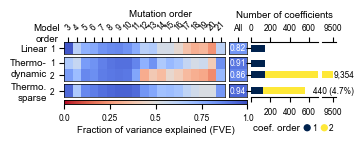

In [29]:
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

fig, ax = plt.subplot_mosaic([['top left', 'top centre', 'top right', 'top right break'],
                              ['biophys left', 'biophys centre', 'biophys right', 'biophys right break'],
                              ['middle left', 'middle centre', 'middle right', 'middle right break'],
                              ['bottom left-centre', 'bottom left-centre', 'bottom right', 'bottom right']],
                            width_ratios = [6, 0.7, 2.5, 0.5],
                            height_ratios = [0.33, 0.67 ,0.37,0.1],
                            figsize=(3.5,0.8))

sns.heatmap(fyn_model_performance_by_nham.iloc[0:1].divide(FEV_correction.loc[0],axis=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['top left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
sns.heatmap(fyn_model_performance_by_nham.iloc[1:].divide(FEV_correction.loc[0],axis=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['biophys left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
sns.heatmap(fyn_sparse_model_performance_by_nham.divide(FEV_correction.loc[0],axis=1).apply(pd.to_numeric), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['middle left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5,cbar_ax=ax['bottom left-centre'],cbar_kws={"orientation": "horizontal", 'location':'bottom'})

#ax['top left'].set_xlabel('Mutation order', fontsize=7)
# Setting y-tick labels explicitly to ensure visibility
ax['top left'].set_xticks([i+0.5 for i in range(fyn_model_performance_by_nham.shape[1])])
ax['top left'].set_xticklabels(fyn_model_performance_by_nham.columns, fontsize=6, rotation=45)
ax['top left'].set_yticks([0.5])
ax['top left'].set_yticklabels(['1'], fontsize=6, rotation=0)
ax['top left'].xaxis.set_label_position('top')
ax['top left'].xaxis.set_ticks_position('top')
ax['top left'].tick_params(axis='y',labelsize=6, labelrotation=0)
ax['middle left'].set_yticks([i+0.5 for i in range(fyn_sparse_model_performance_by_nham.shape[0])])
ax['middle left'].set_yticklabels([str(i+2) for i in range(fyn_sparse_model_performance_by_nham.shape[0])], fontsize=6, rotation=0)
ax['middle left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['middle left'].set_xticks(ticks=[])
ax['biophys left'].set_yticks([i+0.5 for i in range(fyn_model_performance_by_nham.shape[0]-1)])
ax['biophys left'].set_yticklabels([str(i+1) for i in range(fyn_model_performance_by_nham.shape[0]-1)], fontsize=6, rotation=0)
ax['biophys left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['biophys left'].set_xticks(ticks=[])
ax['bottom left-centre'].set_xticks(ticks=np.arange(0,1.25,.25),labels=np.arange(0,1.25,.25), fontsize=6)
ax['bottom left-centre'].set_xlabel('Fraction of variance explained (FVE)', rotation=0, labelpad=2, fontsize=7)

sns.heatmap(fyn_overall_full_model_performance.iloc[0:1]/all_order_FEV, annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['top centre'], linewidths=0, linecolor='black', annot_kws={'color':'white', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['top centre'].set_yticks(ticks=[])
ax['top centre'].set_xticks([i+0.5 for i in range(fyn_overall_full_model_performance.shape[1])])
ax['top centre'].set_xticklabels(fyn_overall_full_model_performance.columns, fontsize=6, rotation=0)
ax['top centre'].xaxis.set_label_position('top')
ax['top centre'].xaxis.set_ticks_position('top')
ax['top centre'].tick_params(axis='both',labelsize=6, labelrotation=0)

sns.heatmap((fyn_overall_full_model_performance.iloc[1:]/all_order_FEV), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['biophys centre'], linewidths=0, linecolor='black', annot_kws={'color':'white', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['biophys centre'].set_yticks(ticks=[])
ax['biophys centre'].set_xticks(ticks=[])

sns.heatmap((fyn_overall_sparse_model_performance/all_order_FEV), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['middle centre'], linewidths=0, linecolor='black', annot_kws={'color':'white', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['middle centre'].set_yticks(ticks=[])
ax['middle centre'].set_xticks(ticks=[])

full_models_terms_by_order.T.iloc[0:1].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['top right'], legend=False, width=0.65)
ax['top right'].invert_yaxis()
ax['top right'].spines[['right','bottom','left']].set_visible(False)
ax['top right'].xaxis.set_label_position('top')
ax['top right'].xaxis.set_ticks_position('top')
ax['top right'].set_xlabel('Number of coefficients', fontsize=7)
ax['top right'].set_yticks(ticks=np.arange(0,1,1), labels=[])
ax['top right'].set_xticks(ticks=np.arange(0,700,200),labels=np.arange(0,700,200))
ax['top right'].set_xlim(0,700)
ax['top right'].tick_params(axis='both',labelsize=6, labelrotation=0)

full_models_terms_by_order.T.iloc[0:1].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['top right break'], legend=False, width=0.65)
ax['top right break'].invert_yaxis()
ax['top right break'].spines[['right','bottom','left']].set_visible(False)
ax['top right break'].xaxis.set_label_position('top')
ax['top right break'].xaxis.set_ticks_position('top')
ax['top right break'].set_yticks(ticks=[], labels=[])
ax['top right break'].set_xticks(ticks=np.arange(9500,9600,200),labels=np.arange(9500,9600,200))
ax['top right break'].set_xlim(9000,9600)
ax['top right break'].tick_params(axis='both',labelsize=6, labelrotation=0)

full_models_terms_by_order.T.iloc[1:].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['biophys right'], legend=False, width=0.65)
ax['biophys right'].invert_yaxis()
ax['biophys right'].spines[['right','bottom','left','top']].set_visible(False)
ax['biophys right'].set_yticks(ticks=np.arange(0,2,1), labels=[])
ax['biophys right'].set_xticks(ticks=[],labels=[])
ax['biophys right'].set_xlim(0,700)
ax['biophys right'].tick_params(axis='both',labelsize=6, labelrotation=0)

full_models_terms_by_order.T.iloc[1:].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['biophys right break'], legend=False, width=0.65)
ax['biophys right break'].invert_yaxis()
ax['biophys right break'].spines[['right','bottom','left','top']].set_visible(False)
ax['biophys right break'].set_yticks(ticks=[], labels=[])
ax['biophys right break'].set_xticks(ticks=[],labels=[])
ax['biophys right break'].set_xlim(9000,9600)
ax['biophys right break'].tick_params(axis='both',labelsize=6, labelrotation=0)

sparse_models_terms_by_order.T.plot(kind='barh', stacked=True, cmap='cividis', ax=ax['middle right'], legend=False, width=0.6)
ax['middle right'].invert_yaxis()
handles, labels = ax['middle right'].get_legend_handles_labels()
ax['middle right'].spines[['right','top','left']].set_visible(False)
ax['middle right'].set_yticks(ticks=np.arange(0,1,1),labels=[])
ax['middle right'].set_xticks(ticks=np.arange(0,700,200),labels=['']+[str(i) for i in np.arange(200,700,200)], fontsize=6)
ax['middle right'].set_xlim(0,700)
ax['middle right'].xaxis.set_ticks_position('bottom')

sparse_models_terms_by_order.T.plot(kind='barh', stacked=True, cmap='cividis', ax=ax['middle right break'], legend=False, width=0.6)
ax['middle right break'].invert_yaxis()
handles, labels = ax['middle right break'].get_legend_handles_labels()
ax['middle right break'].spines[['right','top','left']].set_visible(False)
ax['middle right break'].set_yticks(ticks=[],labels=[])
ax['middle right break'].set_xticks(ticks=np.arange(9500,9600,200),labels=np.arange(9500,9600,200), fontsize=6)
ax['middle right break'].set_xlim(9000,9600)
ax['middle right break'].xaxis.set_ticks_position('bottom')

for axis in ['top left', 'biophys left', 'middle left', 'bottom left-centre', 'top centre', 'biophys centre', 'middle centre']:
    for spine in ax[axis].spines.values():
        spine.set(visible=True,lw=0.5,edgecolor='black')

ax['bottom right'].axis('off')
#legend = ax['bottom right'].legend(handles, labels, title='Coefficient order', ncol=2, frameon=False, fontsize=6, bbox_to_anchor=(0.85,-1.5))
#legend.get_title().set_fontsize('7')
 

class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Create a circle artist
        center = (width / 2, height / 2)
        p = mpatches.Circle(center, radius=min(width, height) / 2, color=orig_handle.get_facecolor())
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

# Define circular patches for each legend handle
circle_handles = [mpatches.Circle((0, 0), radius=3, color=h.patches[0].get_facecolor()) for h in handles]

# Set 'coef. order' as a pseudo-title inline with labels
legend_labels = ['coef. order'] + labels
blank_patch = mpatches.Circle((0, 0), radius=0, color='none')  # Invisible patch for title alignment
circle_handles = [blank_patch] + circle_handles

# Create the legend with custom circular handles and compact layout
legend = ax['bottom right'].legend(circle_handles, legend_labels,
                                   handler_map={mpatches.Circle: HandlerCircle()},  # Use custom circle handler
                                   ncol=3,  # Layout in columns
                                   frameon=False, fontsize=6,
                                   loc='lower center',  # Align legend below the figure
                                   bbox_to_anchor=(0.45, -10),  # Adjust if needed
                                   handletextpad=0.2,  # Reduced spacing between handle and label
                                   labelspacing=0.2,  # Reduced spacing between labels
                                   handlelength=0.8,  # Shorten handle length
                                   columnspacing=0.5)  # Reduced space between columns

# Adjust font size of the "pseudo-title" if necessary
legend.get_texts()[0].set_fontsize(7)

# Retrieve and annotate the middle right break axis with the specific row from `full_models_terms_by_order`
middle_right_break_total = full_models_terms_by_order.T.iloc[2:3][2].values[0]  # Get the specific count

# Only annotate if there's a valid count
if middle_right_break_total > 0:
    # Get the y-coordinate of the bar for row 2 in `middle right break`
    bar_height = ax['middle right break'].patches[0].get_y() + ax['middle right break'].patches[0].get_height() / 2
    ax['middle right break'].text(middle_right_break_total + 180, -1.3, f"{int(middle_right_break_total):,}",
                                  ha='left', va='center', fontsize=6, color='black')

# Retrieve and annotate the middle right axis with the specific row from `sparse_models_terms_by_order`
sparse_row_total = sparse_models_terms_by_order.T.iloc[0:1][2].values[0]
penultimate_total = full_models_terms_by_order.T.iloc[2:3][2].values[0]  # For percentage calculation

# Calculate percentage and annotate
if penultimate_total > 0:
    percentage = (sparse_row_total / penultimate_total) * 100
    # Get the y-coordinate of the bar for row 0 in `middle right`
    bar_height = ax['middle right'].patches[0].get_y() + ax['middle right'].patches[0].get_height() / 2
    ax['middle right break'].text(middle_right_break_total -750, bar_height, f"{int(sparse_row_total)} ({percentage:.1f}%)",
                            ha='left', va='center', fontsize=6, color='black')



fig.text(0.4, 1.2, 'Mutation order', ha='center', fontsize=7)
fig.text(0.075, 0.89, 'Model\norder', ha='center', fontsize=7)
fig.text(0.075, 0.8, 'Linear', va='center', ha='right', rotation='horizontal', fontsize=7)
fig.text(0.075, 0.55, 'Thermo-\ndynamic', va='center', ha='right', rotation='horizontal', fontsize=7)
fig.text(0.075, 0.25, 'Thermo.\nsparse', va='center', ha='right', rotation='horizontal', fontsize=7)

plt.subplots_adjust(hspace=0.2, wspace= 0.06)

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('EBG_FYN_surface_allmochimodelperformancesummary_quantile08.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel J

In [30]:
import pandas as pd
from os import listdir
from os.path import isfile, join

#path = '/Users/albert/Library/CloudStorage/OneDrive-CRG-CentredeRegulacioGenomica/deepCore/Cores_paper_2023/zenodo/'

columns = ['Query','Target','E-value','SeqId','QueryStart', 'QueryEnd','QueryLen', 'TargetStart',
          'TargetEnd','TargetLen', 'Align_len', 'Score', 'QuerySeq', 'TargetSeq', 'mismatch',
           'QueryCov','TargetCov', 'taxid','taxname','taxlineage','lddt','alntmscore','rmsd','prob']

isofolds=pd.read_csv(path+'Fig4/fyn_aln1_AFUniprot',names=columns,sep='\t',low_memory=False)

reliable_isofolds = isofolds.loc[isofolds['alntmscore']>0.6].loc[isofolds['prob']==1].loc[isofolds['QueryStart']<3].loc[isofolds['QueryEnd']>53].loc[isofolds['rmsd']<2].drop_duplicates('TargetSeq').copy()

In [31]:
#transplantable core finding

DTS=['F','L','I','M','V']

wt=reliable_isofolds.iloc[0]['QuerySeq']
mut_pos = [2,16,18,24,26,48,53]
wtcore=''.join([reliable_isofolds.iloc[0]['QuerySeq'][i] for i in mut_pos])

aatype_pos=[]
for i in mut_pos:
    aatyperange=0
    for res in wt[:i]:
        if res == wt[i-1]:
            aatyperange+=1
    aatype_pos.append(aatyperange)
reliable_isofolds['MutPosinlib']='a'
reliable_isofolds["WTcore"] = pd.Series(dtype="object") 
reliable_isofolds["MutCore"] = pd.Series(dtype="object") 
reliable_isofolds["TransplantableAAs"] = pd.Series(dtype="object") 
reliable_isofolds["allDTS"] = pd.Series(dtype="object") 
reliable_isofolds["coreDels"] = pd.Series(dtype="object") 
reliable_isofolds["MutPosTested"] = pd.Series(dtype="object") 
totalerrors=0
for index, row in reliable_isofolds.iterrows():
    query=row.QuerySeq
    target=row.TargetSeq
    target_mut_pos=[]
    query_hyphens=[]
    iterator=0
    for i in query:
        if i=='-':
            query_hyphens.append(iterator)
        iterator+=1
    aligned_target=list(target)
    iterator=0
    for i in query_hyphens:
        del(aligned_target[i+iterator])
        iterator-=1
    aligned_target=''.join(aligned_target)
    mut_pos_test = [x+1 - row.QueryStart for x in mut_pos]
    mut_pos_test = [i - row.QueryStart +1 for i in mut_pos if i >= row.QueryStart-1 and i <= row.QueryEnd-1]
    mut=[]
    for pos in mut_pos_test:
        try:
            mut.append(aligned_target[pos])
        except IndexError:
            totalerrors+=1
    if ''.join(mut) == wtcore:
        reliable_isofolds.at[index,'WTcore']=True
        reliable_isofolds.at[index,'Nham']=0
    else:
        reliable_isofolds.at[index,'WTcore']=False
        nham=0
        for mutres, wtres in zip(mut,wtcore):
            if mutres != wtres:
                nham+=1
        reliable_isofolds.at[index,'Nham']=nham
        
    reliable_isofolds.at[index,'MutCore']=('').join(mut)
    allDTS=True
    coreDels=False
    mutations_in_lib = []
    transplantable_aas = []
    for pos, res in zip([idx for idx, pos in enumerate(mut_pos) if pos >= row.QueryStart-1 and pos <= row.QueryEnd-1], mut):
        if res not in DTS:
            allDTS=False
        else:
            mutations_in_lib.append(mut_pos[pos])
            transplantable_aas.append(res)
        if res == '-':
            coreDels=True
    reliable_isofolds.at[index,'MutPosinlib']=str(mutations_in_lib)
    reliable_isofolds.at[index,'TransplantableAAs']=''.join(transplantable_aas)
    reliable_isofolds.at[index,'allDTS']=allDTS
    reliable_isofolds.at[index,'coreDels']=coreDels 
    reliable_isofolds.at[index,'MutPosTested']=str([i for i in mut_pos if i >= row.QueryStart-1 and i <= row.QueryEnd-1])


### Core transplants

In [32]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig5/mochi/Core/RandomFYN_core_order2_sparse_regularized/task_4/predictions/predicted_phenotypes_supp.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

mut_pos_numbers = [2, 4, 8, 10, 15, 16, 18, 22, 24, 26, 35, 37, 48, 52, 53]
cores = {'P06241' : mut_pos_numbers}
predicted_phenotypes["core"] = pd.Series(dtype="object") 
for index, row in predicted_phenotypes.iterrows():
    core=[]
    for i in cores['P06241']:
        core.append(row.aa_seq[i])
    predicted_phenotypes.at[index,'core'] = ''.join(core)


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

coefs_1storder = pd.read_csv(path+'FigS11/EBG_core_layer_ddGs_scaled_from_additivetrait_order1.txt',
                       sep='\t', index_col=0)
coefs_2ndorder = pd.read_csv(path+'FigS11/EBG_core_layer_ddGs_scaled_from_additivetrait_order2.txt',
                       sep='\t', index_col=0)
coefs_2ndorder_sprsreg = pd.read_csv(path+'FigS11/EBG_core_layer_ddGs_scaled_from_additivetrait_order2_sparse_regularized.txt',
                       sep='\t', index_col=0)

secondorderterms_2ndorder = pd.read_csv(path+'FigS11/EBG_core_layer_order2_secondorderterms_scaled_w_iv_values.txt',
                       sep='\t', index_col=0)

secondorderterms_2ndorder_sprsreg = pd.read_csv(path+'FigS11/EBG_core_layer_order2_sparse_regularized_secondorderterms_scaled_w_iv_values.txt',
                       sep='\t', index_col=0)

folding_ddGs = coefs_2ndorder_sprsreg[['actual_ddGs']].copy().rename(columns={'actual_ddGs':'ddG'})
folding_dddGs = secondorderterms_2ndorder_sprsreg[['id','scaled_ddGs']].copy().set_index('id',drop=True).rename(columns={'scaled_ddGs':'dddG'})

In [34]:
import pandas as pd
from itertools import combinations

fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'

mut_pos_name = [2, 4, 8, 10, 15, 16, 18, 21, 22, 24, 26, 34, 35, 37, 46, 48, 49, 52, 53]

def find_mutations(wt, variant, positions):
    mutations = []
    for pos in positions:
        if wt[pos] != variant[pos]:
            mutations.append(f"{wt[pos]}{pos + 1}{variant[pos]}")
    return mutations

predicted_phenotypes['mutations'] = predicted_phenotypes['aa_seq'].apply(lambda x: ','.join(find_mutations(fyn_wt, x, mut_pos_name)))

def find_mutation_pairs(mutations):
    mutation_list = mutations.split(',')
    pairs = [f"{a}_{b}" for a, b in combinations(mutation_list, 2)]
    return ','.join(pairs)

def compute_iv_scaled_dddG(row, folding_ddGs, folding_dddGs):
    single_mutations = row['mutations'].split(',') if row['mutations'] else []
    mutation_pairs = row['mutation_pairs'].split(',') if row['mutation_pairs'] else []

    ddG_sum = sum(folding_ddGs.loc[mut, 'ddG'] if mut in folding_ddGs.index else 0 for mut in single_mutations)

    dddG_sum = sum(folding_dddGs.loc[pair, 'dddG'] if pair in folding_dddGs.index else 0 for pair in mutation_pairs)

    return ddG_sum + dddG_sum

predicted_phenotypes['mutation_pairs'] = predicted_phenotypes['mutations'].apply(lambda x: find_mutation_pairs(x) if x else '')

predicted_phenotypes['iv_scaled_folding_ddG'] = predicted_phenotypes.apply(
    compute_iv_scaled_dddG, axis=1, folding_ddGs=folding_ddGs, folding_dddGs=folding_dddGs
)

In [35]:
import pandas as pd
from os import listdir
from os.path import isfile, join

columns = ['Query','Target','E-value','SeqId','QueryStart', 'QueryEnd','QueryLen', 'TargetStart',
          'TargetEnd','TargetLen', 'Align_len', 'Score', 'QuerySeq', 'TargetSeq', 'mismatch',
           'QueryCov','TargetCov', 'taxid','taxname','taxlineage','lddt','alntmscore','rmsd','prob']

isofolds=pd.read_csv(path+'Fig4/fyn_aln1_AFUniprot',names=columns,sep='\t')

reliable_isofolds = isofolds.loc[isofolds['alntmscore']>0.6].loc[isofolds['prob']==1].loc[isofolds['QueryStart']<3].loc[isofolds['QueryEnd']>53].loc[isofolds['rmsd']<2].drop_duplicates('TargetSeq').copy()

In [36]:
### Transplantable core finding

allowed_mutations = {0: ['L', 'V', 'F'],
 1: ['V', 'A'],
 2: ['F', 'Y'],
 3: ['P', 'S', 'A'],
 4: ['E', 'D'],
 5: ['I', 'L'],
 6: ['L', 'V', 'I', 'F'],
 7: ['D', 'E'],
 8: ['L', 'V', 'I', 'F'],
 9: ['L', 'V', 'I'],
 10: ['L', 'W'],
 11: ['V', 'G', 'A'],
 12: ['V', 'F', 'I'],
 13: ['F', 'Y'],
 14: ['L', 'I', 'V']}

wt=reliable_isofolds.iloc[0]['QuerySeq']
mut_pos = mut_pos_numbers
wtcore=''.join([reliable_isofolds.iloc[0]['QuerySeq'][i] for i in mut_pos])

aatype_pos=[]
for i in mut_pos:
    aatyperange=0
    for res in wt[:i]:
        if res == wt[i-1]:
            aatyperange+=1
    aatype_pos.append(aatyperange)
reliable_isofolds['MutPosinlib']='a'
totalerrors=0
reliable_isofolds["WTcore"] = pd.Series(dtype="object") 
reliable_isofolds["MutCore"] = pd.Series(dtype="object") 
reliable_isofolds["TransplantableAAs"] = pd.Series(dtype="object") 
reliable_isofolds["allDTS"] = pd.Series(dtype="object") 
reliable_isofolds["coreDels"] = pd.Series(dtype="object") 
reliable_isofolds["MutPosTested"] = pd.Series(dtype="object") 
for index, row in reliable_isofolds.iterrows():
    query=row.QuerySeq
    target=row.TargetSeq
    target_mut_pos=[]
    query_hyphens=[]
    iterator=0
    for i in query:
        if i=='-':
            query_hyphens.append(iterator)
        iterator+=1
    aligned_target=list(target)
    iterator=0
    for i in query_hyphens:
        del(aligned_target[i+iterator])
        iterator-=1
    aligned_target=''.join(aligned_target)
    mut_pos_test = [x+1 - row.QueryStart for x in mut_pos]
    mut_pos_test = [i - row.QueryStart +1 for i in mut_pos if i >= row.QueryStart-1 and i <= row.QueryEnd-1]
    mut=[]
    for pos in mut_pos_test:
        try:
            mut.append(aligned_target[pos])
        except IndexError:
            totalerrors+=1
    if ''.join(mut) == wtcore:
        reliable_isofolds.at[index,'WTcore']=True
        reliable_isofolds.at[index,'Nham']=0
    else:
        reliable_isofolds.at[index,'WTcore']=False
        nham=0
        for mutres, wtres in zip(mut,wtcore):
            if mutres != wtres:
                nham+=1
        reliable_isofolds.at[index,'Nham']=nham
        
    reliable_isofolds.at[index,'MutCore']=('').join(mut)
    allDTS=True
    coreDels=False
    mutations_in_lib = []
    transplantable_aas = []
    for pos, res in zip([idx for idx, pos in enumerate(mut_pos) if pos >= row.QueryStart-1 and pos <= row.QueryEnd-1], mut):
        if res not in allowed_mutations[pos]:
            allDTS=False
        else:
            mutations_in_lib.append(mut_pos[pos])
            transplantable_aas.append(res)
        if res == '-':
            coreDels=True
    reliable_isofolds.at[index,'MutPosinlib']=str(mutations_in_lib)
    reliable_isofolds.at[index,'TransplantableAAs']=''.join(transplantable_aas)
    reliable_isofolds.at[index,'allDTS']=allDTS
    reliable_isofolds.at[index,'coreDels']=coreDels 
    reliable_isofolds.at[index,'MutPosTested']=str([i for i in mut_pos if i >= row.QueryStart-1 and i <= row.QueryEnd-1])


In [37]:
import ast
fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'
def integrate_variant_with_positions(wildtype_seq, variant_seq, mut_positions):
    mut_positions = ast.literal_eval(mut_positions)  # Convert string to list of integers
    fyn_variant = list(wildtype_seq)

    for i, pos in enumerate(mut_positions):
        if i < len(variant_seq):
            fyn_variant[pos] = variant_seq[i]
    
    return ''.join(fyn_variant)

def calculate_differences(variant, wildtype):
    return sum(1 for a, b in zip(variant, wildtype) if a != b)

real_variants = pd.DataFrame()

reliable_isofolds['muts_in_fyn_seq'] = reliable_isofolds.apply(
    lambda row: integrate_variant_with_positions(fyn_wt, row['TransplantableAAs'], row['MutPosinlib']),
    axis=1
)

reliable_isofolds['muts_in_fyn_seq_Nham_aa'] = reliable_isofolds['muts_in_fyn_seq'].apply(lambda variant: calculate_differences(variant, fyn_wt))
reliable_isofolds["core"] = pd.Series(dtype="object") 
for index, row in reliable_isofolds.iterrows():
    reliable_isofolds.at[index,'core']=''.join(row.muts_in_fyn_seq[i] for i in mut_pos_numbers)

In [38]:
from itertools import product
import itertools

mutation_positions = [allowed_mutations[i] for i in range(len(mut_pos_numbers))]
combinations = list(itertools.product(*mutation_positions))

isofold_exist_clasf = pd.DataFrame(index=[''.join(i) for i in combinations])

isofold_exist_clasf = isofold_exist_clasf.join(predicted_phenotypes.set_index('core')[['iv_scaled_folding_ddG']])

isofold_exist_clasf['in_nature_all']=isofold_exist_clasf.index.isin(list(reliable_isofolds.sort_values('SeqId',ascending=False).drop_duplicates('core',keep='first')['core']))
isofold_exist_clasf['in_nature_all']=isofold_exist_clasf['in_nature_all'].astype(int)
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf.index.isin(list(reliable_isofolds.sort_values('SeqId',ascending=False).drop_duplicates('core',keep='first').loc[reliable_isofolds['SeqId']<0.5].loc[reliable_isofolds['SeqId']>0.25]['core']))
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf['in_nature_25_50'].astype(int)
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.sort_values('SeqId',ascending=False).drop_duplicates('core',keep='first').loc[reliable_isofolds['SeqId']<0.75].loc[reliable_isofolds['SeqId']>0.50]['core']))
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf['in_nature_50_75'].astype(int)
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf.index.isin(list(reliable_isofolds.sort_values('SeqId',ascending=False).drop_duplicates('core',keep='first').loc[reliable_isofolds['SeqId']<0.25].loc[reliable_isofolds['SeqId']>0]['core']))
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf['in_nature_0_25'].astype(int)
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.sort_values('SeqId',ascending=False).drop_duplicates('core',keep='first').loc[reliable_isofolds['SeqId']>0.75]['core']))
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf['in_nature_75'].astype(int)

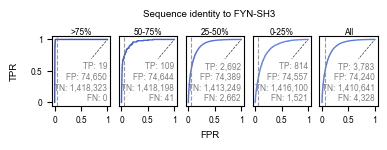

In [39]:
import matplotlib.pyplot as plt
from decimal import Decimal
from sklearn import metrics
import numpy as np
from sklearn.utils import shuffle

plt.rcParams["font.family"] = "Arial"

titles = {'in_nature_all':'All',
         'in_nature_0_25':'0-25%',
         'in_nature_25_50':'25-50%',
         'in_nature_50_75':'50-75%',
         'in_nature_75':'>75%'}

cmap = plt.get_cmap('coolwarm_r')

classifier_performances = pd.DataFrame()
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(2.8*1.5,0.6*1.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.15)

coliterator = 0
for threshold in reversed(['in_nature_all', 'in_nature_0_25', 'in_nature_25_50', 'in_nature_50_75', 'in_nature_75']):

    x = isofold_exist_clasf[['iv_scaled_folding_ddG']]
    y = isofold_exist_clasf[[threshold]]

    x, y = shuffle(x, y, random_state=3)

    fpr, tpr, thresholds = metrics.roc_curve(np.array(y).ravel(), np.array(-1*x).ravel())
    roc_auc = metrics.auc(fpr, tpr)

    target_fpr = 0.05
    idx = (np.abs(fpr - target_fpr)).argmin()
    threshold_at_target_fpr = thresholds[idx]

    predicted = (np.array(-1*x).ravel() >= threshold_at_target_fpr).astype(int)

    tp = np.sum((predicted == 1) & (np.array(y).ravel() == 1))  # True Positives
    fp = np.sum((predicted == 1) & (np.array(y).ravel() == 0))  # False Positives
    tn = np.sum((predicted == 0) & (np.array(y).ravel() == 0))  # True Negatives
    fn = np.sum((predicted == 0) & (np.array(y).ravel() == 1))  # False Negatives

    ax[coliterator].plot(fpr, tpr, lw=1, alpha=1, color=cmap(roc_auc),
                         label=r'(AUC=%0.2f)' % (roc_auc),zorder=2)

    classifier_performances.at[threshold,'AUC']=roc_auc

    ax[coliterator].plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='k', alpha=0.8,zorder=0)

    ax[coliterator].axvline(x=target_fpr, linestyle="dashed", color="gray", lw=0.8, alpha=0.8)

    box_text = f"TP: {tp:,}\nFP: {fp:,}\nTN: {tn:,}\nFN: {fn:,}"
    ax[coliterator].text(0.95, 0.05, box_text, fontsize=6, color='gray',
                         ha='right', va='bottom', transform=ax[coliterator].transAxes,
                         bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3', alpha=0.9),zorder=1)
    
    ax[coliterator].set_title(titles[threshold], fontsize=6, pad=0)
    ax[coliterator].set_xticks(np.arange(0, 1.2, 0.5), [Decimal(i).normalize() for i in np.arange(0, 1.2, 0.5)], fontsize=6)
    ax[coliterator].set_yticks(np.arange(0, 1.2, 0.5), [Decimal(i).normalize() for i in np.arange(0, 1.2, 0.5)], fontsize=6)
    
    if coliterator > 0:
        ax[coliterator].tick_params(axis='y', length=0)
    
    coliterator += 1

fig.text(0.5, -0.25, 'FPR', ha='center', fontsize=7)
fig.text(0.025, 0.5, 'TPR', va='center', rotation='vertical', fontsize=7)
fig.text(0.5, 1.1, 'Sequence identity to FYN-SH3', ha='center', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
plt.subplots_adjust(wspace=0.15)
#fig.savefig('FYN_2ndordersparsemodel_EBGcore_classifier_ROC-AUCs_curves_SeqIds_w_partial_transplants_dGs_calculated_from_scaled_values.svg', dpi=300, transparent=True, bbox_inches='tight')


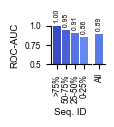

In [40]:
fig, ax = plt.subplot_mosaic([['left','right']],
                            width_ratios = [3.5,1],
                            figsize = (0.7,0.5))
axis=classifier_performances.iloc[:-1].plot.bar(y='AUC', color=cmap(list(classifier_performances['AUC'])), ax=ax['left'], legend=False, width=0.9, ylim=(0,1.05))
ax['left'].set_xticklabels(reversed(['0-25%', '25-50%', '50-75%', '>75%']), fontsize=6, rotation=90)
ax['left'].set_yticks(np.arange(0,1.2,0.25),[str(round(i,2)) for i in np.arange(0,1.2,0.25)], fontsize=6)
ax['left'].set_ylim(0.5,1)
ax['left'].set_xlabel('Seq. ID', fontsize=7)
ax['left'].set_ylabel('ROC-AUC',fontsize=7)
ax['left'].spines[['top','right']].set_visible(False)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=90)

axis=classifier_performances.iloc[-1:].plot.bar(y='AUC', color=cmap(list(classifier_performances.iloc[-1:]['AUC'])), ax=ax['right'], legend=False, width=0.9, ylim=(0,1.05))
ax['right'].spines[['top','right','left']].set_visible(False)
ax['right'].set_yticks([])
ax['right'].set_ylim(0.5,1)
ax['right'].set_xticklabels(reversed(['All']), fontsize=6, rotation=90)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=90)

plt.subplots_adjust(wspace=0.1)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_2ndordersparsemodel_EBGcore_classifier_ROC-AUCs_barplot_SeqIds_w_partial_transplants_dGs_calculated_from_scaled_values.svg', dpi=300, transparent=True, bbox_inches='tight')

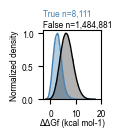

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

panel_width = 2.8 * 1.5 / 5.6
panel_height = 0.6 * 1.5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(panel_width, panel_height))

threshold = 'in_nature_all'
observed = isofold_exist_clasf[isofold_exist_clasf[threshold] == 1]['iv_scaled_folding_ddG']
non_observed = isofold_exist_clasf[isofold_exist_clasf[threshold] == 0]['iv_scaled_folding_ddG']

observed_color = "steelblue"
non_observed_color = "black"

observed_kde = stats.gaussian_kde(observed)
non_observed_kde = stats.gaussian_kde(non_observed)

x_vals = np.linspace(min(observed.min(), non_observed.min()),
                     max(observed.max(), non_observed.max()), 100)
observed_density = observed_kde(x_vals)
non_observed_density = non_observed_kde(x_vals)

observed_density /= observed_density.max()
non_observed_density /= non_observed_density.max()

ax.plot(x_vals, observed_density, color=observed_color, linewidth=1, label="True")
ax.plot(x_vals, non_observed_density, color=non_observed_color, linewidth=1, label="False")

hist_observed, bin_edges_observed = np.histogram(observed, bins=30, density=True)
hist_non_observed, bin_edges_non_observed = np.histogram(non_observed, bins=30, density=True)

hist_observed = hist_observed / hist_observed.max()
hist_non_observed = hist_non_observed / hist_non_observed.max()

bin_centers_observed = 0.5 * (bin_edges_observed[:-1] + bin_edges_observed[1:])
bin_centers_non_observed = 0.5 * (bin_edges_non_observed[:-1] + bin_edges_non_observed[1:])

ax.bar(bin_centers_observed, hist_observed, width=np.diff(bin_edges_observed),
       alpha=0.4, color=observed_color, edgecolor=None)
ax.bar(bin_centers_non_observed, hist_non_observed, width=np.diff(bin_edges_non_observed),
       alpha=0.3, color=non_observed_color, edgecolor=None)

ax.set_xticks(np.arange(0, 30, 10))
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)

n_observed = len(observed)
n_non_observed = len(non_observed)
ax.text(0, 1.3, f"True n={n_observed:,}", color=observed_color, fontsize=6,
        ha='left', va='top', transform=ax.transAxes)
ax.text(0, 1.15, f"False n={n_non_observed:,}", color=non_observed_color, fontsize=6,
        ha='left', va='top', transform=ax.transAxes)


ax.set_xlabel('ΔΔGf (kcal mol-1)', fontsize=6, labelpad=0)
ax.set_ylabel('Normalized density', fontsize=6, labelpad=2)

plt.show()


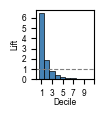

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

n_deciles = 10

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((2.8*1.5)/5.6, 0.6*1.5))

threshold = 'in_nature_all'
df = isofold_exist_clasf[['iv_scaled_folding_ddG', threshold]].copy()
df = df.rename(columns={threshold: 'observed'})

df['score'] = -1 * df['iv_scaled_folding_ddG']

df = df.sort_values(by='score', ascending=False).reset_index(drop=True)

overall_rate = df['observed'].mean()

df['decile'] = pd.qcut(np.arange(len(df)), q=n_deciles, labels=np.arange(1, n_deciles+1))

lift_df = df.groupby('decile')['observed'].agg(['mean', 'count']).reset_index()
lift_df['lift'] = lift_df['mean'] / overall_rate
lift_df = lift_df.sort_values(by='decile')

ax.bar(lift_df['decile'].astype(str), lift_df['lift'],
       color='steelblue', edgecolor='k', alpha=1, lw=0.5,width=1)
ax.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)

ax.set_xlabel('Decile', fontsize=6, labelpad=0)
ax.set_ylabel('Lift', fontsize=6, labelpad=2)
ax.set_yticks(np.arange(0,7,1))
ax.set_xticks(np.arange(0,11,2))
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)

### Surface transplants

In [43]:
### Transplantable surface finding

mut_pos_numbers = [0, 5, 6, 7, 9, 11, 12, 13, 14, 19, 20, 27, 30, 31, 32, 33, 41, 42, 51, 55, 56]


allowed_mutations = {0: ['A', 'D', 'G', 'N', 'S', 'T'],
 1: ['I', 'M', 'V', 'L'],
 2: ['F', 'Y'],
 3: ['N', 'D'],
 4: ['A',  'D',  'G',  'N',  'S',  'I',  'M',  'V',  'H',  'K',  'L',  'P',  'Q',  'R',  'T',  'E'],
 5: ['A',  'D',  'G',  'N',  'S',  'I',  'M',  'V',  'H',  'K',  'L',  'P',  'Q',  'T',  'E',  'R'],
 6: ['A', 'D', 'G', 'N', 'S', 'I', 'M', 'V', 'K', 'R', 'E', 'T'],
 7: ['A', 'D', 'G', 'N', 'S', 'H', 'K', 'P', 'Q', 'R', 'T', 'E'],
 8: ['G', 'N', 'S', 'D'],
 9: ['A', 'D', 'N', 'I', 'M', 'V', 'K', 'L', 'P', 'Q', 'T', 'E', 'H'],
 10: ['I', 'V', 'E', 'K'],
 11: ['I', 'V', 'L'],
 12: ['A',  'D',  'G',  'N',  'I',  'M',  'V',  'H',  'K',  'L',  'P',  'Q',  'R',  'T',  'E',  'S'],
 13: ['D', 'G', 'N', 'S', 'K', 'R', 'E'],
 14: ['A', 'D', 'N', 'S', 'K', 'R', 'T', 'E', 'G'],
 15: ['G', 'E', 'D'],
 16: ['A', 'D', 'G', 'N', 'S', 'I', 'M', 'V', 'K', 'R', 'E', 'T'],
 17: ['N', 'S', 'K', 'R', 'T'],
 18: ['S', 'T', 'N'],
 19: ['A', 'I', 'M', 'V', 'K', 'L', 'Q', 'T', 'E', 'P'],
 20: ['I', 'M', 'L', 'V']}

wt=reliable_isofolds.iloc[0]['QuerySeq']
mut_pos = mut_pos_numbers
wtcore=''.join([reliable_isofolds.iloc[0]['QuerySeq'][i] for i in mut_pos])

aatype_pos=[]
for i in mut_pos:
    aatyperange=0
    for res in wt[:i]:
        if res == wt[i-1]:
            aatyperange+=1
    aatype_pos.append(aatyperange)
reliable_isofolds['MutPosinlib']='a'
totalerrors=0
reliable_isofolds["WTcore"] = pd.Series(dtype="object") 
reliable_isofolds["MutCore"] = pd.Series(dtype="object") 
reliable_isofolds["TransplantableAAs"] = pd.Series(dtype="object") 
reliable_isofolds["allDTS"] = pd.Series(dtype="object") 
reliable_isofolds["coreDels"] = pd.Series(dtype="object") 
reliable_isofolds["MutPosTested"] = pd.Series(dtype="object") 
for index, row in reliable_isofolds.iterrows():
    query=row.QuerySeq
    target=row.TargetSeq
    target_mut_pos=[]
    query_hyphens=[]
    iterator=0
    for i in query:
        if i=='-':
            query_hyphens.append(iterator)
        iterator+=1
    aligned_target=list(target)
    iterator=0
    for i in query_hyphens:
        del(aligned_target[i+iterator])
        iterator-=1
    aligned_target=''.join(aligned_target)
    mut_pos_test = [x+1 - row.QueryStart for x in mut_pos]
    mut_pos_test = [i - row.QueryStart +1 for i in mut_pos if i >= row.QueryStart-1 and i <= row.QueryEnd-1]
    mut=[]
    for pos in mut_pos_test:
        try:
            mut.append(aligned_target[pos])
        except IndexError:
            totalerrors+=1
    if ''.join(mut) == wtcore:
        reliable_isofolds.at[index,'WTcore']=True
        reliable_isofolds.at[index,'Nham']=0
    else:
        reliable_isofolds.at[index,'WTcore']=False
        nham=0
        for mutres, wtres in zip(mut,wtcore):
            if mutres != wtres:
                nham+=1
        reliable_isofolds.at[index,'Nham']=nham
        
    reliable_isofolds.at[index,'MutCore']=('').join(mut)
    allDTS=True
    coreDels=False
    mutations_in_lib = []
    transplantable_aas = []
    for pos, res in zip([idx for idx, pos in enumerate(mut_pos) if pos >= row.QueryStart-1 and pos <= row.QueryEnd-1], mut):
        if res not in allowed_mutations[pos]:
            allDTS=False
        else:
            mutations_in_lib.append(mut_pos[pos])
            transplantable_aas.append(res)
        if res == '-':
            coreDels=True
    reliable_isofolds.at[index,'MutPosinlib']=str(mutations_in_lib)
    reliable_isofolds.at[index,'TransplantableAAs']=''.join(transplantable_aas)
    reliable_isofolds.at[index,'allDTS']=allDTS
    reliable_isofolds.at[index,'coreDels']=coreDels 
    reliable_isofolds.at[index,'MutPosTested']=str([i for i in mut_pos if i >= row.QueryStart-1 and i <= row.QueryEnd-1])


In [44]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig5/mochi/Surface/RandomFYN_surface_order2_sparse_regularized/task_4/predictions/predicted_phenotypes_supp.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

cores = {'P06241' : mut_pos_numbers}
predicted_phenotypes["core"] = pd.Series(dtype="object") 
for index, row in predicted_phenotypes.iterrows():
    core=[]
    for i in cores['P06241']:
        core.append(row.aa_seq[i])
    predicted_phenotypes.at[index,'core'] = ''.join(core)


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

coefs_1storder = pd.read_csv(path+'FigS12/EBG_surface_layer_ddGs_scaled_from_additivetrait_orderorder1.txt',
                       sep='\t', index_col=0)
coefs_2ndorder_sprsreg = pd.read_csv(path+'FigS12/EBG_surface_layer_ddGs_scaled_from_additivetrait_order2_sparse_regularized.txt',
                       sep='\t', index_col=0)

secondorderterms_2ndorder_sprsreg = pd.read_csv(path+'FigS12/EBG_surface_layer_order2_sparse_regularized_secondorderterms_scaled_w_iv_values.txt',
                       sep='\t', index_col=0)

folding_ddGs = coefs_2ndorder_sprsreg[['actual_ddGs']].copy().rename(columns={'actual_ddGs':'ddG'})
folding_dddGs = secondorderterms_2ndorder_sprsreg[['id','scaled_ddGs']].copy().set_index('id',drop=True).rename(columns={'scaled_ddGs':'dddG'})

In [46]:
import pandas as pd
from itertools import combinations

fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'

mut_pos_name = [0, 5, 6, 7, 9, 11, 12, 13, 14, 19, 20, 27, 30, 31, 32, 33, 41, 42, 51, 55, 56]

def find_mutations(wt, variant, positions):
    mutations = []
    for pos in positions:
        if wt[pos] != variant[pos]:
            mutations.append(f"{wt[pos]}{pos + 1}{variant[pos]}")
    return mutations

predicted_phenotypes['mutations'] = predicted_phenotypes['aa_seq'].apply(lambda x: ','.join(find_mutations(fyn_wt, x, mut_pos_name)))

def find_mutation_pairs(mutations):
    mutation_list = mutations.split(',')
    pairs = [f"{a}_{b}" for a, b in combinations(mutation_list, 2)]
    return ','.join(pairs)

def compute_iv_scaled_dddG(row, folding_ddGs, folding_dddGs):
    single_mutations = row['mutations'].split(',') if row['mutations'] else []
    mutation_pairs = row['mutation_pairs'].split(',') if row['mutation_pairs'] else []

    ddG_sum = sum(folding_ddGs.loc[mut, 'ddG'] if mut in folding_ddGs.index else 0 for mut in single_mutations)

    dddG_sum = sum(folding_dddGs.loc[pair, 'dddG'] if pair in folding_dddGs.index else 0 for pair in mutation_pairs)

    return ddG_sum + dddG_sum

predicted_phenotypes['mutation_pairs'] = predicted_phenotypes['mutations'].apply(lambda x: find_mutation_pairs(x) if x else '')

predicted_phenotypes['iv_scaled_folding_ddG'] = predicted_phenotypes.apply(
    compute_iv_scaled_dddG, axis=1, folding_ddGs=folding_ddGs, folding_dddGs=folding_dddGs
)

In [47]:
import ast
fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'
def integrate_variant_with_positions(wildtype_seq, variant_seq, mut_positions):
    mut_positions = ast.literal_eval(mut_positions)  # Convert string to list of integers
    fyn_variant = list(wildtype_seq)

    for i, pos in enumerate(mut_positions):
        if i < len(variant_seq):
            fyn_variant[pos] = variant_seq[i]
    
    return ''.join(fyn_variant)

def calculate_differences(variant, wildtype):
    return sum(1 for a, b in zip(variant, wildtype) if a != b)

real_variants = pd.DataFrame()

reliable_isofolds['muts_in_fyn_seq'] = reliable_isofolds.apply(
    lambda row: integrate_variant_with_positions(fyn_wt, row['TransplantableAAs'], row['MutPosinlib']),
    axis=1
)

reliable_isofolds['muts_in_fyn_seq_Nham_aa'] = reliable_isofolds['muts_in_fyn_seq'].apply(lambda variant: calculate_differences(variant, fyn_wt))
reliable_isofolds["core"] = pd.Series(dtype="object") 
for index, row in reliable_isofolds.iterrows():
    reliable_isofolds.at[index,'core']=''.join(row.muts_in_fyn_seq[i] for i in mut_pos_numbers)

In [48]:
from itertools import product
import itertools

isofold_exist_clasf = pd.DataFrame(index=predicted_phenotypes['core'])

isofold_exist_clasf = isofold_exist_clasf.join(predicted_phenotypes.set_index('core')[['iv_scaled_folding_ddG']])

isofold_exist_clasf['in_nature_all']=isofold_exist_clasf.index.isin(list(reliable_isofolds.sort_values('SeqId',ascending=False).drop_duplicates('core',keep='first')['core']))
isofold_exist_clasf['in_nature_all']=isofold_exist_clasf['in_nature_all'].astype(int)
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf.index.isin(list(reliable_isofolds.sort_values('SeqId',ascending=False).drop_duplicates('core',keep='first').loc[reliable_isofolds['SeqId']<0.5].loc[reliable_isofolds['SeqId']>0.25]['core']))
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf['in_nature_25_50'].astype(int)
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.sort_values('SeqId',ascending=False).drop_duplicates('core',keep='first').loc[reliable_isofolds['SeqId']<0.75].loc[reliable_isofolds['SeqId']>0.50]['core']))
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf['in_nature_50_75'].astype(int)
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf.index.isin(list(reliable_isofolds.sort_values('SeqId',ascending=False).drop_duplicates('core',keep='first').loc[reliable_isofolds['SeqId']<0.25].loc[reliable_isofolds['SeqId']>0]['core']))
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf['in_nature_0_25'].astype(int)
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.sort_values('SeqId',ascending=False).drop_duplicates('core',keep='first').loc[reliable_isofolds['SeqId']>0.75]['core']))
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf['in_nature_75'].astype(int)

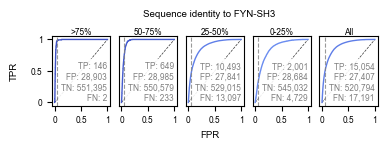

In [49]:
import matplotlib.pyplot as plt
from decimal import Decimal
from sklearn import metrics
import numpy as np
from sklearn.utils import shuffle

plt.rcParams["font.family"] = "Arial"

titles = {'in_nature_all':'All',
         'in_nature_0_25':'0-25%',
         'in_nature_25_50':'25-50%',
         'in_nature_50_75':'50-75%',
         'in_nature_75':'>75%'}

cmap = plt.get_cmap('coolwarm_r')

classifier_performances = pd.DataFrame()
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(2.8*1.5,0.6*1.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.15)

coliterator = 0
for threshold in reversed(['in_nature_all', 'in_nature_0_25', 'in_nature_25_50', 'in_nature_50_75', 'in_nature_75']):

    x = isofold_exist_clasf[['iv_scaled_folding_ddG']]
    y = isofold_exist_clasf[[threshold]]

    x, y = shuffle(x, y, random_state=3)

    fpr, tpr, thresholds = metrics.roc_curve(np.array(y).ravel(), np.array(-1*x).ravel())
    roc_auc = metrics.auc(fpr, tpr)

    target_fpr = 0.05
    idx = (np.abs(fpr - target_fpr)).argmin()
    threshold_at_target_fpr = thresholds[idx]

    predicted = (np.array(-1*x).ravel() >= threshold_at_target_fpr).astype(int)

    tp = np.sum((predicted == 1) & (np.array(y).ravel() == 1))  # True Positives
    fp = np.sum((predicted == 1) & (np.array(y).ravel() == 0))  # False Positives
    tn = np.sum((predicted == 0) & (np.array(y).ravel() == 0))  # True Negatives
    fn = np.sum((predicted == 0) & (np.array(y).ravel() == 1))  # False Negatives

    ax[coliterator].plot(fpr, tpr, lw=1, alpha=1, color=cmap(roc_auc),
                         label=r'(AUC=%0.2f)' % (roc_auc),zorder=2)

    classifier_performances.at[threshold,'AUC']=roc_auc

    ax[coliterator].plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='k', alpha=0.8,zorder=0)

    ax[coliterator].axvline(x=target_fpr, linestyle="dashed", color="gray", lw=0.8, alpha=0.8)

    box_text = f"TP: {tp:,}\nFP: {fp:,}\nTN: {tn:,}\nFN: {fn:,}"
    ax[coliterator].text(0.95, 0.05, box_text, fontsize=6, color='gray',
                         ha='right', va='bottom', transform=ax[coliterator].transAxes,
                         bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3', alpha=0.9),zorder=1)
    
    ax[coliterator].set_title(titles[threshold], fontsize=6, pad=0)
    ax[coliterator].set_xticks(np.arange(0, 1.2, 0.5), [Decimal(i).normalize() for i in np.arange(0, 1.2, 0.5)], fontsize=6)
    ax[coliterator].set_yticks(np.arange(0, 1.2, 0.5), [Decimal(i).normalize() for i in np.arange(0, 1.2, 0.5)], fontsize=6)
    
    if coliterator > 0:
        ax[coliterator].tick_params(axis='y', length=0)
    
    coliterator += 1

fig.text(0.5, -0.25, 'FPR', ha='center', fontsize=7)
fig.text(0.025, 0.5, 'TPR', va='center', rotation='vertical', fontsize=7)
fig.text(0.5, 1.1, 'Sequence identity to FYN-SH3', ha='center', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
plt.subplots_adjust(wspace=0.15)

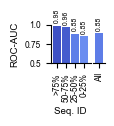

In [50]:
fig, ax = plt.subplot_mosaic([['left','right']],
                            width_ratios = [3.5,1],
                            figsize = (0.7,0.5))
axis=classifier_performances.iloc[:-1].plot.bar(y='AUC', color=cmap(list(classifier_performances['AUC'])), ax=ax['left'], legend=False, width=0.9, ylim=(0,1.05))
ax['left'].set_xticklabels(reversed(['0-25%', '25-50%', '50-75%', '>75%']), fontsize=6, rotation=90)
ax['left'].set_yticks(np.arange(0,1.2,0.25),[str(round(i,2)) for i in np.arange(0,1.2,0.25)], fontsize=6)
ax['left'].set_ylim(0.5,1)
ax['left'].set_xlabel('Seq. ID', fontsize=7)
ax['left'].set_ylabel('ROC-AUC',fontsize=7)
ax['left'].spines[['top','right']].set_visible(False)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=90)

axis=classifier_performances.iloc[-1:].plot.bar(y='AUC', color=cmap(list(classifier_performances.iloc[-1:]['AUC'])), ax=ax['right'], legend=False, width=0.9, ylim=(0,1.05))
ax['right'].spines[['top','right','left']].set_visible(False)
ax['right'].set_yticks([])
ax['right'].set_ylim(0.5,1)
ax['right'].set_xticklabels(reversed(['All']), fontsize=6, rotation=90)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=90)

plt.subplots_adjust(wspace=0.1)
plt.rcParams['svg.fonttype'] = 'none'

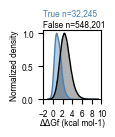

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

panel_width = 2.8 * 1.5 / 5.6
panel_height = 0.6 * 1.5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(panel_width, panel_height))

threshold = 'in_nature_all'
observed = isofold_exist_clasf[isofold_exist_clasf[threshold] == 1]['iv_scaled_folding_ddG']
non_observed = isofold_exist_clasf[isofold_exist_clasf[threshold] == 0]['iv_scaled_folding_ddG']

observed_color = "steelblue"
non_observed_color = "black"

observed_kde = stats.gaussian_kde(observed)
non_observed_kde = stats.gaussian_kde(non_observed)

x_vals = np.linspace(min(observed.min(), non_observed.min()),
                     max(observed.max(), non_observed.max()), 100)
observed_density = observed_kde(x_vals)
non_observed_density = non_observed_kde(x_vals)

observed_density /= observed_density.max()
non_observed_density /= non_observed_density.max()

ax.plot(x_vals, observed_density, color=observed_color, linewidth=1, label="True")
ax.plot(x_vals, non_observed_density, color=non_observed_color, linewidth=1, label="False")

hist_observed, bin_edges_observed = np.histogram(observed, bins=30, density=True)
hist_non_observed, bin_edges_non_observed = np.histogram(non_observed, bins=30, density=True)

hist_observed = hist_observed / hist_observed.max()
hist_non_observed = hist_non_observed / hist_non_observed.max()

bin_centers_observed = 0.5 * (bin_edges_observed[:-1] + bin_edges_observed[1:])
bin_centers_non_observed = 0.5 * (bin_edges_non_observed[:-1] + bin_edges_non_observed[1:])

ax.bar(bin_centers_observed, hist_observed, width=np.diff(bin_edges_observed),
       alpha=0.4, color=observed_color, edgecolor=None)
ax.bar(bin_centers_non_observed, hist_non_observed, width=np.diff(bin_edges_non_observed),
       alpha=0.3, color=non_observed_color, edgecolor=None)

ax.set_xticks(np.arange(-2, 11, 2))
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)

n_observed = len(observed)
n_non_observed = len(non_observed)
ax.text(0, 1.3, f"True n={n_observed:,}", color=observed_color, fontsize=6,
        ha='left', va='top', transform=ax.transAxes)
ax.text(0, 1.15, f"False n={n_non_observed:,}", color=non_observed_color, fontsize=6,
        ha='left', va='top', transform=ax.transAxes)


ax.set_xlabel('ΔΔGf (kcal mol-1)', fontsize=6, labelpad=0)
ax.set_ylabel('Normalized density', fontsize=6, labelpad=2)

plt.show()


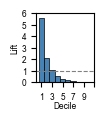

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

n_deciles = 10

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((2.8*1.5)/5.6, 0.6*1.5))

threshold = 'in_nature_all'
df = isofold_exist_clasf[['iv_scaled_folding_ddG', threshold]].copy()
df = df.rename(columns={threshold: 'observed'})

df['score'] = -1 * df['iv_scaled_folding_ddG']

df = df.sort_values(by='score', ascending=False).reset_index(drop=True)

overall_rate = df['observed'].mean()

df['decile'] = pd.qcut(np.arange(len(df)), q=n_deciles, labels=np.arange(1, n_deciles+1))

lift_df = df.groupby('decile')['observed'].agg(['mean', 'count']).reset_index()
lift_df['lift'] = lift_df['mean'] / overall_rate
lift_df = lift_df.sort_values(by='decile')

ax.bar(lift_df['decile'].astype(str), lift_df['lift'],
       color='steelblue', edgecolor='k', alpha=1, lw=0.5,width=1)
ax.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)

ax.set_xlabel('Decile', fontsize=6, labelpad=0)
ax.set_ylabel('Lift', fontsize=6, labelpad=2)
ax.set_yticks(np.arange(0,7,1))
ax.set_xticks(np.arange(0,11,2))
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)